In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind, mannwhitneyu
from scipy.stats import pearsonr, spearmanr
from DataLoaders.SubjectLoader import SubjectLoader
from DataLoaders.GutMBLoader import GutMBLoader
from DataLoaders.MBLoader import MBLoader
import seaborn as sns
    
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.metrics import r2_score
from pingouin import partial_corr
from DataLoaders.CGMLoader import CGMLoader
from scipy.stats import rankdata
import os

from DataLoaders.StudySpecificLoaders.IBDLoader import IBDLoader

from skbio.diversity.alpha import shannon
def do_correl_pearson(ser1, ser2, name1 = 'microbiome column', name2 = 'phenotype column'):
        fig = plt.figure(figsize = (5,5))
        ax = fig.add_subplot(111)
        joined = pd.concat([ser1,ser2], axis = 1).dropna()
        ax.plot(joined[ser1.name], joined[ser2.name], 'o', color = 'DarkGrey', markersize = 10, mew = 0, alpha = 0.7)
        ax.set_xlabel(name1)
        ax.set_ylabel(name2)
        
        print(pearsonr(joined[ser1.name], joined[ser2.name]))
        print(spearmanr(joined[ser1.name], joined[ser2.name]))
        ax.grid()
        name_fig = name1.replace(' ', '_').replace('.', '_')+'_'+name2.replace(' ', '_').replace('.', '_')
        print(name_fig)
        plt.savefig('/net/mraid08/export/genie/LabData/Data/StudySpecificData/T1D/microbiome/'+name_fig)
        
def do_pearson(ser1, ser2, name1 = 'microbiome column', name2 = 'phenotype column'):
        joined = pd.concat([ser1,ser2], axis = 1).dropna()
        return pearsonr(joined[ser1.name], joined[ser2.name])
    
def do_mw(ser1, ser2, name1 = 'microbiome column', name2 = 'phenotype column'):
        return mannwhitneyu(ser1[ser1.index.isin(ser2[ser2==True].index)], ser1[ser1.index.isin(ser2[ser2==False].index)])


    
def do_mw(ser1, ser2, name1 = 'microbiome column', name2 = 'phenotype column'):
        return mannwhitneyu(ser1.values, ser2.values)

    
def do_mw_boxplot(ser1, ser2, name1 = 'microbiome column', name2 = 'phenotype column'):
    fig, ax = plt.subplots()
    joined = pd.concat([ser1,ser2], axis = 1).dropna()
    joined.boxplot(ser1.name, by = ser2.name, ax = ax)
   # ax.set_title('')
    plt.show()
    
    
def do_mw_boxplot_2samp(ser1, ser2, name1 = 'microbiome column', name2 = 'phenotype column'):
    fig = plt.figure(figsize = (5,5))
    ax = fig.add_subplot(111)
    ser1.name = 'abund'
    ser1 = pd.DataFrame(ser1)
    ser2.name = 'abund'
    ser2 = pd.DataFrame(ser2)
    ser1['is_t1d'] = 1
    ser2['is_t1d'] = 0
    joined = ser1.append(ser2)
    joined.boxplot('abund', by = 'is_t1d', ax = ax)
   # ax.set_title('')
    plt.show()
        
global_path='/net/mraid08/export/genie/LabData/Data/StudySpecificData/T1D/microbiome/'


def shannon_divercity(ser):
    return shannon(ser[ser>0.0001].values)

def richness(ser):
    return ser[ser>0.0001].shape[0]

def fdr(p_vals):

    ranked_p_values = rankdata(p_vals)
    fdr = p_vals * len(p_vals) / ranked_p_values
    fdr[fdr > 1] = 1

    return fdr
def do_pearson(ser1, ser2, name1='microbiome column', name2='phenotype column'):
    joined = pd.concat([ser1, ser2], axis=1).dropna()
    return pearsonr(joined[ser1.name], joined[ser2.name]) 

def do_spearman(ser1, ser2, name1='microbiome column', name2='phenotype column'):
    joined = pd.concat([ser1, ser2], axis=1).dropna()
    return spearmanr(joined[ser1.name], joined[ser2.name]) 

def do_correl_pearson_numb_adj(ser1, ser2, covar):
        joined = pd.concat([ser1,ser2, covar], axis = 1).dropna()
        return  partial_corr(joined, ser1.name,ser2.name, covar.name)[['r', 'p-val']].values[0]
    
    
def rename_bact_name(col):
    return col
def compare_2_groups(df, group1, group2, group1_name='main', group2_name='control'):
    comparison_table = pd.DataFrame(columns = [group1_name+' mean', group1_name+' std',\
                                               group2_name+' mean', group2_name+' std',
                                              'ttest_pvalue'])
    signif_cols = []
    comparison_table.loc['number of samples', group1_name+' mean'] = len(set(group1))
    comparison_table.loc['number of samples', group2_name+' mean'] = len(set(group2))
    for col in df.columns:
        A=df[col].loc[group1].dropna().values
        B=df[col].loc[group2].dropna().values
        if len(A)<20:
            continue
        comparison_table.loc[col, group1_name+' mean'] = df[col].loc[group1].dropna().mean()
        comparison_table.loc[col, group1_name+' std'] =  df[col].loc[group1].dropna().std()
        comparison_table.loc[col, group2_name+' mean'] = df[col].loc[group2].dropna().mean()
        comparison_table.loc[col, group2_name+' std'] =  df[col].loc[group2].dropna().std()
        comparison_table.loc[col, 'ttest_pvalue'] =  ttest_ind(A, B)[1]
        comparison_table.loc[col, 'mw_pvalue'] =  mannwhitneyu(A, B)[1]
        if ttest_ind(A, B)[1]<0.05:
         #   print(col)
            signif_cols = signif_cols+[col]
          #  fig, ax = plt.subplots()
          #  draw_plot(A, B, col)
        #    plt.close()
    return comparison_table, signif_cols

def do_a_heatmap_and_corr_matrix(A, B, title=''):
    A = A.rename(columns = {col:rename_bact_name(col) for col in A.columns})
    A = A[[col for col in A.columns if 'unknown' not in col]]
    res_pval = pd.DataFrame()
    res_corr = pd.DataFrame()

            
            
    for col1 in A.columns:
        for col2 in B.columns:
            if col1==col2 or col2=='age' or col1=='age':
                continue
#do_spearman
            res_pval.loc[col1, col2] = do_pearson(A[col1], B[col2])[1]
            res_corr.loc[col1, col2] = do_pearson(A[col1], B[col2])[0]

         #   res_pval.loc[col1, col2] = do_correl_pearson_numb_adj(A[col1], B[col2], B['age'])[1]
        #    res_corr.loc[col1, col2] = do_correl_pearson_numb_adj(A[col1], B[col2], B['age'])[0]
        

    sign_corr = pd.DataFrame()
    sign_pval = pd.DataFrame()

    for col in res_pval.columns:
        new_pval = fdr(res_pval[col]).sort_values()
        signif = new_pval[new_pval < 0.1]
        if signif.shape[0] > 0:
            for ind in signif.index:
                print(ind, signif.loc[ind])
                do_correl_pearson(A[ind], B[col], ind,  col)
                sign_corr.loc[ind, col] = res_corr.loc[ind, col]
                sign_pval.loc[ind, col] = res_pval.loc[ind, col]
    sign_pval.to_csv(os.path.join(global_path, 'pvalues_'+title+'.csv' ))
    sign_corr.to_csv(os.path.join(global_path,'corr_' + title + '.csv'))
    fig, ax = plt.subplots(figsize = (7, 9))
    cmap = sns.diverging_palette(230,0, 90, 60, as_cmap=True)
# plot heatmap
    sns.heatmap(sign_corr.fillna(0).T, annot=False, fmt=".2f", 
           linewidths=0, cmap=cmap, vmin=-1, vmax=1, square=True, cbar=False)
   # plt.show()
    fig.savefig('/net/mraid08/export/genie/LabData/Data/StudySpecificData/T1D//microbiome//sign_corr_'+title+'.png' )
 #   fig.savefig('/net/mraid08/export/genie/LabData/Data/StudySpecificData/tenk_itamar//sign_corr_'+title+'.png' )

/home/godnean/.local/lib/python3.7/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt


In [7]:
t1d_adults_reg_codes = ['2011588', '2117136', '2130667', '2149698', '2152850', '2161740',
       '2179494', '2179877', '2181552', '2184915', '2399467', '2823868',
       '2345589', '2059615', '2205761', '2214578', '2221997', '2222186',
       '2223758', '2266842', '2312966', '2316939', '2339080', '2341635',
       '2347848', '2351413', '2380640', '2389355', '2389693', '2434655',
       '2456073', '2463506', '2476957', '2524032', '2527367', '2529577',
       '2554360', '2554949', '2565375', '2590032', '2602050', '2604953',
       '2605343', '2611664', '2620679', '2624552', '2656143', '2671824',
       '2677865', '2680480', '2705869', '2707991', '2708497', '2720736',
       '2736823', '2737013', '2767492', '2768815', '2772936', '2787563',
       '2859637', '2859961', '2870689', '2879802', '2883048', '2886461',
       '2902755', '2936379', '2940942', '2942935', '2946283', '2953310',
       '2990383', '2998285']

control_d2_reg_codes = ['D2_23637', 'D2_16545', 'D2_123457445', 'D2_123480802',
       'D2_123480800', 'D2_123479376', 'D2_123479282', 'D2_123479736',
       'D2_123479938', 'D2_123479920', 'D2_123480159', 'D2_123479640',
       'D2_123478529', 'D2_123479267', 'D2_123479395', 'D2_123479388',
       'D2_123480128', 'D2_123479923', 'D2_123479018', 'D2_123479070',
       'D2_123479165', 'D2_123479746', 'D2_123479159', 'D2_123479336',
       'D2_123479559', 'D2_123479373', 'D2_123479638', 'D2_123479197',
       'D2_123479554', 'D2_123479269', 'D2_123479447', 'D2_123480914',
       'D2_123479944', 'D2_123479818', 'D2_123478806', 'D2_123479104',
       'D2_123479063', 'D2_123479056', 'D2_123479122', 'D2_123478974',
       'D2_123479066', 'D2_123480747', 'D2_123480413', 'D2_123480695',
       'D2_123479164', 'D2_46170', 'D2_123479246', 'D2_123479187',
       'D2_123480430', 'D2_123478990', 'D2_123479087', 'D2_123480657',
       'D2_123480581', 'D2_123480659', 'D2_123480749', 'D2_123479934',
       'D2_123480672', 'D2_123479042', 'D2_123478995', 'D2_123480559',
       'D2_123480360', 'D2_123479088', 'D2_123480466', 'D2_123480827',
       'D2_123479582', 'D2_123479183', 'D2_123479303', 'D2_123480236',
       'D2_123480575', 'D2_123479730', 'D2_123478890', 'D2_123479616',
       'D2_123480208', 'D2_123480877', 'D2_123479439', 'D2_123477980',
       'D2_123480901', 'D2_123478896', 'D2_123479163', 'D2_123479072',
       'D2_123479597', 'D2_123478924', 'D2_123480792', 'D2_123479707',
       'D2_123480478', 'D2_123477510', 'D2_123478704', 'D2_123478889',
       'D2_123478823', 'D2_123478869', 'D2_123478835', 'D2_123480563',
       'D2_123483573', 'D2_123480181', 'D2_123484441', 'D2_123485119',
       'D2_123484486', 'D2_123483859', 'D2_123483268', 'D2_34499',
       'D2_123483544', 'D2_123483942', 'D2_123484189', 'D2_123483971',
       'D2_123483688', 'D2_123483148', 'D2_123479490', 'D2_123480101',
       'D2_123480448', 'D2_123485062', 'D2_123483455', 'D2_123479537',
       'D2_123483405', 'D2_123479669', 'D2_123480205', 'D2_123485041',
       'D2_123480068', 'D2_123480277', 'D2_123479235', 'D2_123482889',
       'D2_123482921', 'D2_123480921', 'D2_123483319', 'D2_123483043',
       'D2_123484929', 'D2_123479240', 'D2_123483322', 'D2_123480347',
       'D2_123480179', 'D2_123480183', 'D2_123479780', 'D2_123457905',
       'D2_123485036', 'D2_123484086', 'D2_123480112', 'D2_123484398',
       'D2_123484064', 'D2_123483898', 'D2_123483168', 'D2_123483260',
       'D2_123479783', 'D2_123487259', 'D2_123483228', 'D2_123484789',
       'D2_123483585', 'D2_123480245', 'D2_123483525', 'D2_123480366',
       'D2_123483796', 'D2_123484058', 'D2_123484156', 'D2_123484712',
       'D2_123479435', 'D2_123484280', 'D2_123484446', 'D2_123484743',
       'D2_123484642', 'D2_123483334', 'D2_123484366', 'D2_123482967',
       'D2_123484802', 'D2_123484354', 'D2_123482821', 'D2_123480895',
       'D2_123484423', 'D2_123484664', 'D2_123480911', 'D2_123484607',
       'D2_123484568', 'D2_123483860', 'D2_123483982', 'D2_123480096',
       'D2_123482500', 'D2_21297', 'D2_19997', 'D2_26921', 'D2_27589',
       'D2_25747', 'D2_26535', 'D2_25975', 'D2_9388', 'D2_30956',
       'D2_39822', 'D2_30176', 'D2_30537', 'D2_30801', 'D2_32531',
       'D2_32930', 'D2_32881', 'D2_30932', 'D2_32416', 'D2_37536',
       'D2_33223', 'D2_33073', 'D2_35102', 'D2_34874', 'D2_33684',
       'D2_37895', 'D2_41047', 'D2_40974', 'D2_39026', 'D2_33945',
       'D2_35354', 'D2_35489', 'D2_35834', 'D2_38369', 'D2_31839',
       'D2_36647', 'D2_34843', 'D2_34200', 'D2_33942', 'D2_33436',
       'D2_38262', 'D2_33751', 'D2_34629', 'D2_38343', 'D2_35589',
       'D2_39476', 'D2_42154', 'D2_38253', 'D2_49099', 'D2_46361',
       'D2_49088', 'D2_41671', 'D2_39997', 'D2_40462', 'D2_41771',
       'D2_46438', 'D2_41150', 'D2_39135', 'D2_37617', 'D2_38871',
       'D2_49551', 'D2_46225', 'D2_46799', 'D2_123457258', 'D2_49642',
       'D2_43297', 'D2_42232', 'D2_42539', 'D2_123458982', 'D2_50613',
       'D2_42263', 'D2_45435', 'D2_44137', 'D2_123457201', 'D2_50947',
       'D2_123458101', 'D2_43782', 'D2_43273', 'D2_123457429',
       'D2_123456973', 'D2_123457988', 'D2_47244', 'D2_48022',
       'D2_123457725', 'D2_46755', 'D2_44208', 'D2_50772', 'D2_123459837',
       'D2_123459460', 'D2_123467313', 'D2_123463963', 'D2_123465792',
       'D2_123464371', 'D2_123463848', 'D2_123468185', 'D2_123463794',
       'D2_123475299', 'D2_123460461', 'D2_123463827', 'D2_123463962',
       'D2_123460264', 'D2_123470423', 'D2_123464117', 'D2_123467302',
       'D2_123466315', 'D2_123464606', 'D2_123468336', 'D2_123466802',
       'D2_123466345', 'D2_123462092', 'D2_123464210', 'D2_123469072',
       'D2_123466641', 'D2_123481160', 'D2_123480989', 'D2_123473392',
       'D2_123469773', 'D2_123474421', 'D2_123473788', 'D2_123474070',
       'D2_123473895', 'D2_123469466', 'D2_123486696', 'D2_123486186']

/home/godnean/.local/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/home/godnean/.local/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.8, the latest is 0.3.12.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [8]:
len(set(t1d_adults_reg_codes))

74

In [9]:
dates = pd.read_excel('/net/mraid08/export/genie/LabData/Data/StudySpecificData/T1D//enrollment_date.xlsx')


dates['RegistrationCode'] = dates['RegistrationCode'].astype(str)

dates=dates.set_index('RegistrationCode')

dates = dates[dates.index.isin(t1d_adults_reg_codes)]
dates

,Date,month,year
RegistrationCode,,,
2705869,2017-07-26,7,2017
2565375,2017-08-30,8,2017
2527367,2017-06-09,6,2017
2940942,2017-08-16,8,2017
2149698,2017-09-28,9,2017
...,...,...,...
2463506,2019-01-06,1,2019
2351413,2018-12-30,12,2018
2736823,2018-07-29,7,2018


In [10]:


all_mbl = GutMBLoader()
segata_species = all_mbl.get_data(df = 'segata_species', reg_ids = t1d_adults_reg_codes, groupby_reg='largest').df


In [12]:
all_mbl.get_data(df = 'segata_species', reg_ids = t1d_adults_reg_codes, groupby_reg='largest').df.index

Index(['2011588FD3287_v0_fullrun', '2117136FD3414_v0_fullrun',
       '2130667FD3409_v0_fullrun', '2149698FD3307_v0_fullrun',
       '2152850FD3325_v0_fullrun', '2161740FD3289_v0_fullrun',
       '2179494FD3399_v0_fullrun', '2179877FD3315_v0_fullrun',
       '2181552FD3397_v0_fullrun', '2184915FD3398_v0_fullrun',
       '22001806511462_v0_fullrun', '22001806514045_v0_fullrun',
       '22001806514048_v0_fullrun', '22001806514052_v0_fullrun',
       '2205761FD3321_v0_fullrun', '2214578FD3344_v0_fullrun',
       '2221997FD3405_v0_fullrun', '2222186FD3323_v0_fullrun',
       '2223758FD3351_v0_fullrun', '2266842FD3295_v0_fullrun',
       '2312966FD3329_v0_fullrun', '2316939FD3367_v0_fullrun',
       '2339080FD3345_v0_fullrun', '2341635FD3306_v0_fullrun',
       '2347848FD3316_v0_fullrun', '2351413FD3411_v0_fullrun',
       '2380640FD3304_v0_fullrun', '2389355FD3294_v0_fullrun',
       '2389693FD3372_v0_fullrun', '2434655FD3296_v0_fullrun',
       '2456073FD3356_v0_fullrun', '2463506FD3413_v

In [13]:
celiac = ['2103540',  '2130360', '2311735', '2718102', '2264805', '2696293', '2768372']

all_mbl = GutMBLoader()
all_mb_md = all_mbl.get_data(df = 'segata_species',reg_ids=t1d_adults_reg_codes, study_ids=[6], groupby_reg='largest', take_log = True, min_col_present_frac=0.25).df_metadata.set_index('RegistrationCode')
#all_mb_md = all_mb_md[~all_mb_md.index.isin(['2565375FD3314_v0_fullrun'])]



td_microbiome_species = all_mbl.get_data(df = 'segata_species',reg_ids=t1d_adults_reg_codes,groupby_reg='first', study_ids=[6],min_col_present_frac=0.35,take_log = True)
td_microbiome_species = td_microbiome_species.df.join(td_microbiome_species.df_metadata[['RegistrationCode']]).set_index('RegistrationCode')

td_microbiome_species = td_microbiome_species[~td_microbiome_species.index.isin(celiac)]


td_microbiome_genus = all_mbl.get_data(df = 'segata_genus',reg_ids=t1d_adults_reg_codes, study_ids=[6], groupby_reg='largest', take_log = True, min_col_present_frac=0.35)
td_microbiome_genus = td_microbiome_genus.df.join(td_microbiome_genus.df_metadata[['RegistrationCode']]).set_index('RegistrationCode')
td_microbiome_genus = td_microbiome_genus[~td_microbiome_genus.index.isin(celiac)]

td_microbiome_family = all_mbl.get_data(df = 'segata_family',reg_ids=t1d_adults_reg_codes, study_ids=[6], groupby_reg='largest', take_log = True, min_col_present_frac=0.35)
td_microbiome_family = td_microbiome_family.df.join(td_microbiome_family.df_metadata[['RegistrationCode']]).set_index('RegistrationCode')

td_microbiome_family = td_microbiome_family[~td_microbiome_family.index.isin(celiac)]
td_microbiome_family = td_microbiome_family.loc[t1d_adults_reg_codes]
print(td_microbiome_family.shape)

(74, 79)


In [40]:
all_mbl = GutMBLoader()
pnp1_microbiome_species = all_mbl.get_data(df = 'segata_species',groupby_reg='first', reg_ids = control_d2_reg_codes, take_log = True,study_ids=[1000],min_col_present_frac=0.3)
pnp1_microbiome_species = pnp1_microbiome_species.df.join(pnp1_microbiome_species.df_metadata[['RegistrationCode']]).set_index('RegistrationCode')




pnp1_microbiome_genus = all_mbl.get_data(df = 'segata_genus', study_ids=[1000], reg_ids = control_d2_reg_codes, groupby_reg='largest', take_log = True, min_col_present_frac=0.25)
pnp1_microbiome_genus = pnp1_microbiome_genus.df.join(pnp1_microbiome_genus.df_metadata[['RegistrationCode']]).set_index('RegistrationCode')


pnp1_microbiome_family = all_mbl.get_data(df = 'segata_family', study_ids=[1000], reg_ids = control_d2_reg_codes,groupby_reg='largest', take_log = True, min_col_present_frac=0.25)
pnp1_microbiome_family = pnp1_microbiome_family.df.join(pnp1_microbiome_family.df_metadata[['RegistrationCode']]).set_index('RegistrationCode')
pnp1_microbiome_family = pnp1_microbiome_family[~pnp1_microbiome_family.index.isin(celiac)]


In [17]:
from DataLoaders.BloodTestsLoader import BloodTestsLoader
from DataLoaders.BodyMeasuresLoader import BodyMeasuresLoader


btl = BloodTestsLoader()

btld = btl.get_data(groupby_reg='first', study_ids=[6]).df.reset_index().set_index('RegistrationCode')


btld = btld.groupby(btld.index).first()

ml = BodyMeasuresLoader()

mld = ml.get_data(groupby_reg='first',study_ids=[6]).df.reset_index().set_index('RegistrationCode')

mld = mld.groupby(mld.index).first()


from DataLoaders.CGMLoader import CGMLoader
def time_in_good_range(one):
    return one[one>70][one<180].shape[0]/one.shape[0]

cgml=CGMLoader()
cgmld = cgml.get_data(study_ids = [6]).df

cgm_features  = pd.DataFrame()

cgm_features['average'] = cgmld.groupby(level='RegistrationCode')['GlucoseValue'].mean()
cgm_features['noise'] = cgmld.groupby(level='RegistrationCode')['GlucoseValue'].std()
cgm_features['variability'] = cgmld.groupby(level='RegistrationCode')['GlucoseValue'].std()/cgmld.groupby(level='RegistrationCode')['GlucoseValue'].mean()
cgm_features['ppgr_95p'] = cgmld.groupby(level='RegistrationCode')['PPGR'].quantile(0.95)
cgm_features['ppgr_median'] = cgmld.groupby(level='RegistrationCode')['PPGR'].quantile(0.5)
cgm_features['time_in_good_range'] = cgmld.groupby(level='RegistrationCode')['GlucoseValue'].apply(time_in_good_range)


from DataLoaders import DietLoggingLoader
dll = DietLoggingLoader.DietLoggingLoader()

dlld = dll.get_data(study_ids=6)


log = dll.add_nutrients(dlld.df, nutrient_list=['energy_kcal', 'carbohydrate_g', 'protein_g', 'totallipid_g'])
log = log.reset_index()
log['Day']  = log['Date'].astype(str).str[:10]
log = log.reset_index().groupby('RegistrationCode')[['energy_kcal','carbohydrate_g','protein_g','totallipid_g']].sum()
log = log.reset_index()
log['carb_ratio'] = log['carbohydrate_g']/ log['energy_kcal']*400
log['protein_ratio'] = log['protein_g']/ log['energy_kcal']*400
log['lipid_ratio'] = log['totallipid_g']/ log['energy_kcal']*900

cgm_features = cgm_features.join(log.set_index('RegistrationCode')[['carb_ratio','protein_ratio','lipid_ratio' ]])

all_mb_md['year'] = all_mb_md['Date'].apply(lambda x: x.year)
dates = pd.read_excel('/net/mraid08/export/genie/LabData/Data/StudySpecificData/T1D//enrollment_date.xlsx')


dates['RegistrationCode'] = dates['RegistrationCode'].astype(str)
dates=dates.set_index('RegistrationCode')
#all_mb_md['age'] = dates['year']+all_mb_md['age']-2018
#all_mb_md.loc['2590032', age] = 18


md = pd.concat([all_mb_md[['age', 'gender']], mld[['weight', 'bmi']], btld[[
    'bt__hdl_cholesterol',
       'bt__glucose','bt__triglycerides', 
       'bt__ldl_cholesterol', 'bt__hba1c', 
       'bt__total_cholesterol']],cgm_features ]) 





md = md.groupby(md.index).first()
#.dropna(subset=['bt__hba1c'])

###comment out if you want everyone

#md = md[md['age']>17]
md = md[md.index.isin(td_microbiome_family.index)]
#.dropna(subset=['bt__hba1c'])
reg_ids = md.index
md_with_age = md
#[md.index.isin(td_microbiome_family.index)].dropna(subset=['bt__hba1c']).index

In [103]:
btld[btld.index.isin(t1d_adults_reg_codes)].describe().dropna(axis=1).to_csv(os.path.join(global_path, 'bt_stats.csv'))

In [18]:
sl = SubjectLoader()

t1d_subj = sl.get_data(groupby_reg='first', study_ids=6)


all_t2d_subj = t1d_subj.df.reset_index().set_index('RegistrationCode')

dates2 = dates.loc[all_t2d_subj.index]


t2d_all_with_dates = pd.concat([all_t2d_subj, dates['year']], axis=1)


t2d_all_with_dates['age'] = t2d_all_with_dates['year']-t2d_all_with_dates['yob']

#print(t2d_all_with_dates[t2d_all_with_dates['age']>17])
t2d_all_with_dates.loc[reg_ids]['age'].mean()

32.25675675675676

In [19]:
td_microbiome_family[td_microbiome_family.index.duplicated()]

,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|fSGB__3150,k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Coriobacteriales|f__no_consensus|fSGB__2991,k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__no_consensus|f__no_consensus|fSGB__2993,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|fSGB__595,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|fSGB__602,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Barnesiellaceae|fSGB__604,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Odoribacteraceae|fSGB__589,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|fSGB__579,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|fSGB__592,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|fSGB__672,...,k__unknown|p__unknown|c__unknown|o__unknown|f__unknown|fSGB__2834,k__unknown|p__unknown|c__unknown|o__unknown|f__unknown|fSGB__2841,k__unknown|p__unknown|c__unknown|o__unknown|f__unknown|fSGB__2953,k__unknown|p__unknown|c__unknown|o__unknown|f__unknown|fSGB__3005,k__unknown|p__unknown|c__unknown|o__unknown|f__unknown|fSGB__3023,k__unknown|p__unknown|c__unknown|o__unknown|f__unknown|fSGB__3038,k__unknown|p__unknown|c__unknown|o__unknown|f__unknown|fSGB__3049,k__unknown|p__unknown|c__unknown|o__unknown|f__unknown|fSGB__3059,k__unknown|p__unknown|c__unknown|o__unknown|f__unknown|fSGB__3062,k__unknown|p__unknown|c__unknown|o__unknown|f__unknown|fSGB__3069
RegistrationCode,,,,,,,,,,,,,,,,,,,,,


In [ ]:
md[['age','gender','weight','bmi','bt__triglycerides','bt__hba1c','average','time_in_good_range', 'carb_ratio','protein_ratio','lipid_ratio']].describe().to_csv('/net/mraid08/export/genie/LabData/Data/StudySpecificData/T1D//microbiome//cohort_basics.csv')


In [22]:
md.columns

md = md[['bt__hdl_cholesterol', 'bt__triglycerides', 'bt__total_cholesterol', 'bt__hba1c',
        'average', 'time_in_good_range', 'bt__ldl_cholesterol']]

In [97]:
yod = pd.read_excel('/net/mraid08/export/genie/LabData/Data/StudySpecificData/T1D/year_of_diagnosis.xlsx', engine='openpyxl')
yod['RegistrationCode'] = yod['RegistrationCode'].astype(str)
yod = yod[yod['RegistrationCode'].isin(t1d_adults_reg_codes)]
yod['year_Of_diagnosis'] = 2018-yod['Year']
yod['year_Of_diagnosis'].describe()

count    60.000000
mean     14.600000
std       9.625531
min       3.000000
25%       7.750000
50%      12.000000
75%      18.250000
max      44.000000
Name: year_Of_diagnosis, dtype: float64

In [44]:
from DataLoaders.BloodTestsLoader import BloodTestsLoader
from DataLoaders.BodyMeasuresLoader import BodyMeasuresLoader


btl = BloodTestsLoader()

btld = btl.get_data(groupby_reg='first',reg_ids = control_d2_reg_codes, study_ids=[1000]).df.reset_index().set_index('RegistrationCode')


btld = btld.groupby(btld.index).first()



md_d2 =  btld[['bt__hdl_cholesterol',
       'bt__glucose',  'bt__triglycerides',
       'bt__ldl_cholesterol', 'bt__hba1c',
       'bt__total_cholesterol']]

md_d2

#reg_ids = md[md.index.isin(td_microbiome_family.index)].dropna(subset=['bt__hba1c']).index

,bt__hdl_cholesterol,bt__glucose,bt__triglycerides,bt__ldl_cholesterol,bt__hba1c,bt__total_cholesterol
RegistrationCode,,,,,,
D2_123456973,45.0,NaN,62.0,NaN,5.1,124.0
D2_123457201,83.0,85.0,70.0,NaN,4.9,202.0
D2_123457258,87.0,95.0,69.0,NaN,NaN,199.0
D2_123457429,NaN,NaN,NaN,NaN,NaN,NaN
D2_123457445,69.0,90.0,37.0,NaN,NaN,152.0
...,...,...,...,...,...,...
D2_49642,NaN,NaN,NaN,NaN,NaN,NaN
D2_50613,NaN,84.0,NaN,NaN,NaN,NaN
D2_50772,45.0,91.0,53.0,NaN,5.1,133.0


In [45]:
al_micr_t1d = td_microbiome_species.join(td_microbiome_genus).join(td_microbiome_family)

In [46]:
al_micr_d2 = pnp1_microbiome_species.join(pnp1_microbiome_genus).join(pnp1_microbiome_family)

In [ ]:
sp1= 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp|fSGB__1439|gSGB__3529|sSGB__4715'

In [47]:
al_micr_d2

,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_adolescentis|fSGB__3150|gSGB__10624|sSGB__17244,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_bifidum|fSGB__3150|gSGB__10628|sSGB__17256,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_longum|fSGB__3150|gSGB__10625|sSGB__17248,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_longum|fSGB__3150|gSGB__10625|sSGB__17249,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_pseudocatenulatum|fSGB__3150|gSGB__10624|sSGB__17237,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_caccae|fSGB__595|gSGB__1377|sSGB__1877,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_cellulosilyticus|fSGB__595|gSGB__1369|sSGB__1844,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_clarus|fSGB__595|gSGB__1363|sSGB__1832,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_dorei|fSGB__595|gSGB__1353|sSGB__1815,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_eggerthii|fSGB__595|gSGB__1362|sSGB__1829,...,k__unknown|p__unknown|c__unknown|o__unknown|f__unknown|fSGB__2841,k__unknown|p__unknown|c__unknown|o__unknown|f__unknown|fSGB__2953,k__unknown|p__unknown|c__unknown|o__unknown|f__unknown|fSGB__2954,k__unknown|p__unknown|c__unknown|o__unknown|f__unknown|fSGB__3005,k__unknown|p__unknown|c__unknown|o__unknown|f__unknown|fSGB__3023,k__unknown|p__unknown|c__unknown|o__unknown|f__unknown|fSGB__3038,k__unknown|p__unknown|c__unknown|o__unknown|f__unknown|fSGB__3059,k__unknown|p__unknown|c__unknown|o__unknown|f__unknown|fSGB__3062,k__unknown|p__unknown|c__unknown|o__unknown|f__unknown|fSGB__3069,k__unknown|p__unknown|c__unknown|o__unknown|f__unknown|fSGB__3070
RegistrationCode,,,,,,,,,,,,,,,,,,,,,
D2_23637,-4.000000,-4.000000,-3.806126,-4.000000,-4.000000,-3.145688,-4.000000,-4.000000,-2.104930,-1.723207,...,-4.000000,-4.000000,-4.000000,-2.877813,-3.189778,-3.368364,-2.901008,-2.075001,-4.000000,-4.000000
D2_16545,-4.000000,-4.000000,-2.792752,-3.679875,-2.315088,-1.712470,-3.689799,-3.844511,-0.920081,-3.520385,...,-3.733370,-3.296466,-4.000000,-2.679284,-3.088615,-3.172582,-3.225806,-4.000000,-3.091906,-4.000000
D2_123457445,-2.082300,-3.247231,-2.636847,-3.661625,-4.000000,-3.212916,-2.692644,-2.669193,-1.326811,-1.770728,...,-3.622920,-2.882110,-4.000000,-3.512749,-4.000000,-2.787347,-3.085888,-4.000000,-4.000000,-4.000000
D2_123480802,-4.000000,-4.000000,-1.601677,-4.000000,-1.339931,-1.331257,-4.000000,-4.000000,-0.992184,-4.000000,...,-4.000000,-4.000000,-4.000000,-4.000000,-3.136423,-3.211962,-4.000000,-4.000000,-4.000000,-4.000000
D2_123480800,-3.418425,-4.000000,-3.939442,-4.000000,-4.000000,-1.976022,-4.000000,-3.391028,-4.000000,-4.000000,...,-3.706172,-4.000000,-4.000000,-2.983876,-3.238424,-3.424514,-2.936954,-4.000000,-4.000000,-4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D2_123474070,-2.535414,-4.000000,-2.607257,-3.554620,-2.155091,-2.353614,-2.668220,-2.864534,-2.324838,-1.339473,...,-2.704781,-3.281755,-3.210612,-3.276529,-3.001063,-2.846582,-2.970284,-3.009913,-3.529005,-4.000000
D2_123473895,-4.000000,-4.000000,-2.575304,-4.000000,-3.167442,-1.573056,-4.000000,-4.000000,-0.748044,-4.000000,...,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000
D2_123469466,-4.000000,-4.000000,-3.914907,-4.000000,-3.451202,-1.870770,

ARO-PWY: chorismate biosynthesis I 0.027254134688958768
(0.4267446180045004, 0.00018540227679563788)
SpearmanrResult(correlation=0.5570133127532317, pvalue=3.7441346725070614e-07)
ARO-PWY:_chorismate_biosynthesis_I_average
PWY-7197: pyrimidine deoxyribonucleotide phosphorylation 0.03161008584463035
(-0.38428796136648935, 0.0008601383903300775)
SpearmanrResult(correlation=-0.4132098527236479, pvalue=0.0003091884426247876)
PWY-7197:_pyrimidine_deoxyribonucleotide_phosphorylation_average
COMPLETE-ARO-PWY: superpathway of aromatic amino acid biosynthesis 0.03246414243872664
(0.4399022140461982, 0.00011042225319294775)
SpearmanrResult(correlation=0.4928291208437842, pvalue=1.0933321761743484e-05)
COMPLETE-ARO-PWY:_superpathway_of_aromatic_amino_acid_biosynthesis_average
PWY-7208: superpathway of pyrimidine nucleobases salvage 0.03405685405544842
(-0.4100352911972033, 0.00034751891893314713)
SpearmanrResult(correlation=-0.4396102643256802, pvalue=0.00011172509594956026)
PWY-7208:_superpathwa

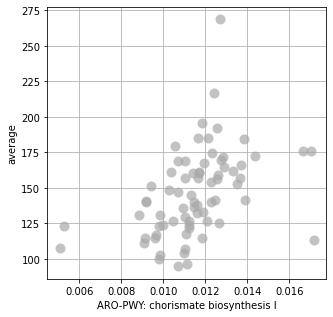

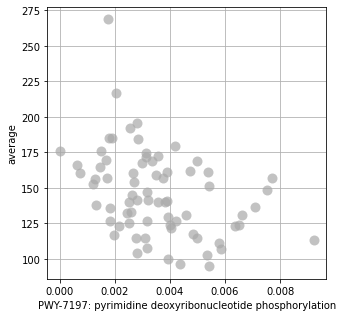

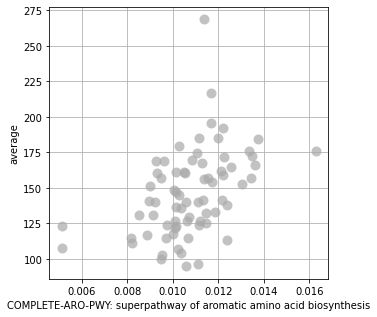

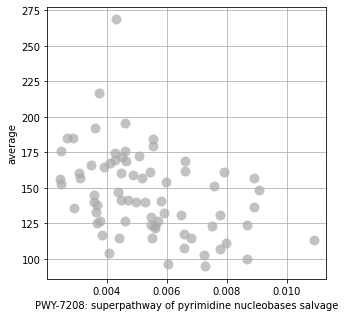

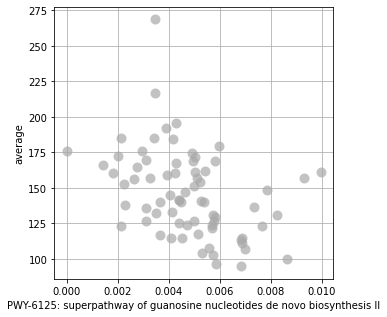

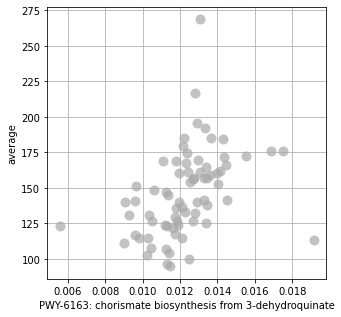

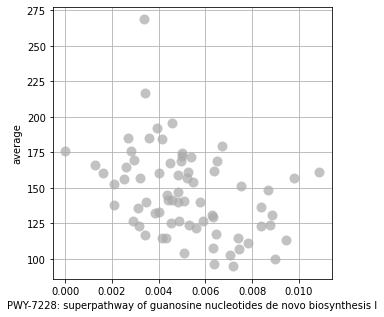

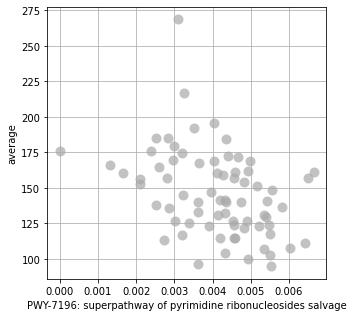

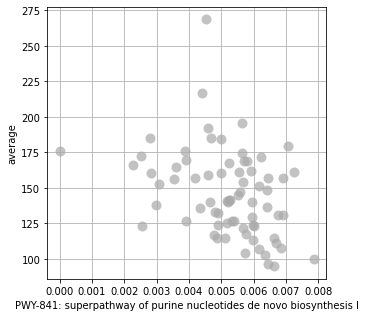

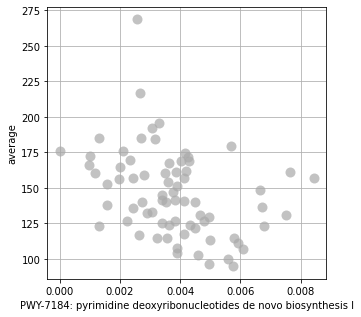

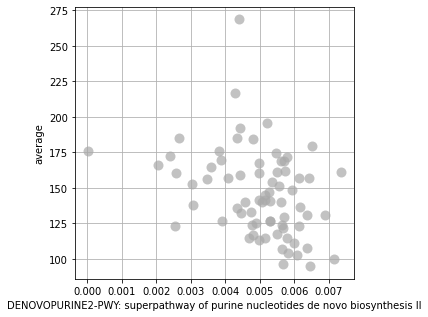

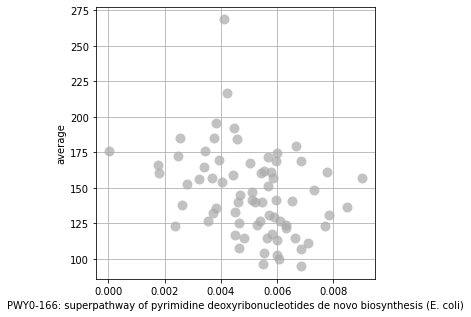

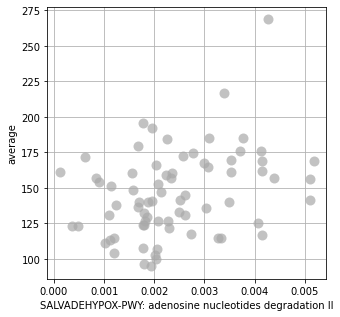

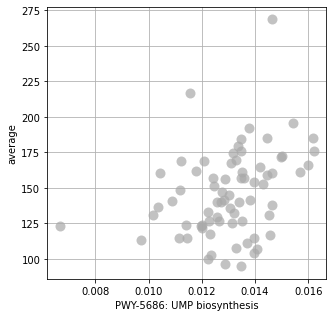

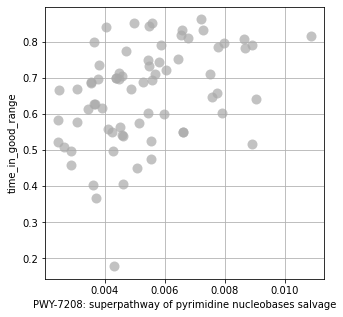

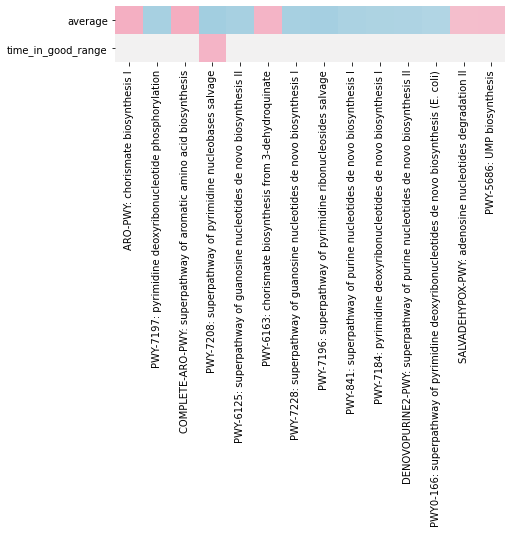

In [56]:
rel_pathways = pd.read_pickle('/net/mraid08/export/genie/LabData/Data/StudySpecificData/T1D/relative_pathways.df')
all_path =rel_pathways.notna().sum()
interesting_pathways = all_path[all_path>100].index
rel_pathways = rel_pathways[interesting_pathways].fillna(0.00001)
td_microbiome_family = all_mbl.get_data(df = 'segata_family', study_ids=[6], groupby_reg='largest', take_log = True, min_col_present_frac=0.25)

rel_pathways = rel_pathways.join(td_microbiome_family.df_metadata[['RegistrationCode']])

rel_pathways = rel_pathways.dropna(subset=['RegistrationCode']).set_index('RegistrationCode')
rel_pathways = rel_pathways[rel_pathways.index.isin(reg_ids)]
do_a_heatmap_and_corr_matrix(rel_pathways, md, 'associations_pathways_adults_pearson.jpg')

COMPLETE-ARO-PWY: superpathway of aromatic amino acid biosynthesis 0.03452847947695436
(0.4205542805565299, 0.00023488761548948542)
SpearmanrResult(correlation=0.4928291208437842, pvalue=1.0933321761743484e-05)
COMPLETE-ARO-PWY:_superpathway_of_aromatic_amino_acid_biosynthesis_average
PWY-7208: superpathway of pyrimidine nucleobases salvage 0.03645281010479692
(-0.4081739683866334, 0.0003719674500489482)
SpearmanrResult(correlation=-0.4396102643256802, pvalue=0.00011172509594956026)
PWY-7208:_superpathway_of_pyrimidine_nucleobases_salvage_average
PWY-6163: chorismate biosynthesis from 3-dehydroquinate 0.03939995290584547
(0.39798005115606794, 0.0005360537810319111)
SpearmanrResult(correlation=0.5684288378673871, pvalue=1.902912186037625e-07)
PWY-6163:_chorismate_biosynthesis_from_3-dehydroquinate_average
ARO-PWY: chorismate biosynthesis I 0.06340410363939843
(0.422802697879938, 0.00021566021646053884)
SpearmanrResult(correlation=0.5570133127532317, pvalue=3.7441346725070614e-07)
ARO-PW

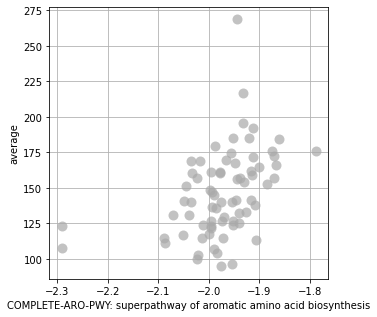

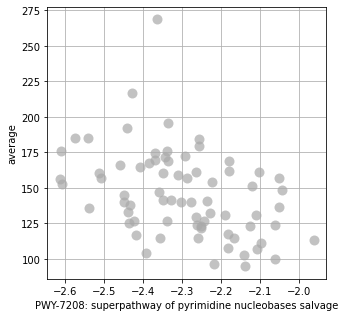

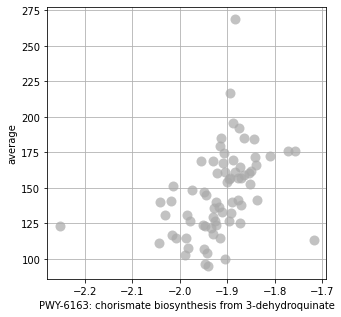

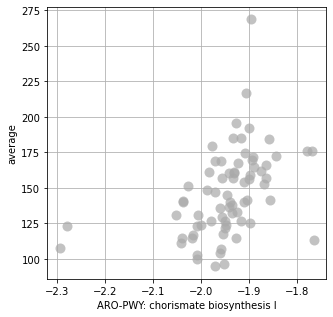

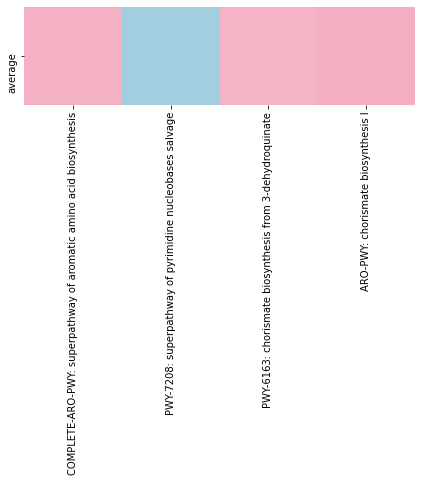

In [57]:
do_a_heatmap_and_corr_matrix(rel_pathways.apply(lambda x: np.log10(x)), md[[col for col in md.columns if 'trig' not in col]], 'associations_pathways_adults_pearson_log')

In [ ]:
pathway_log = rel_pathways.apply(lambda x: np.log10(x))

#pathway_log['PWY-7198: pyrimidine deoxyribonucleotides de novo biosynthesis IV'].hist()
#plt.show()


do_correl_pearson(pathway_log['PWY-5677: succinate fermentation to butanoate'], md['bt__triglycerides'])

In [ ]:
md.columns

In [ ]:
md['ppgr_95p'].hist()

In [ ]:
do_correl_pearson(al_micr_t1d[sp1], md['protein_ratio'])

In [ ]:
sp1='k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_CAG_122|fSGB__1422|gSGB__3487|sSGB__4659'

In [ ]:
do_correl_pearson(td_microbiome_species[sp1].apply(lambda x: np.log10(x)), md['average'])

k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Faecalibacterium|s__Faecalibacterium_prausnitzii|fSGB__3058|gSGB__9741|sSGB__15339 0.03343497866621961
(-0.41440688504820544, 0.0002674798293297569)
SpearmanrResult(correlation=-0.3949616954441897, pvalue=0.0005441162323530225)
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Faecalibacterium|s__Faecalibacterium_prausnitzii|fSGB__3058|gSGB__9741|sSGB__15339_bt__total_cholesterol


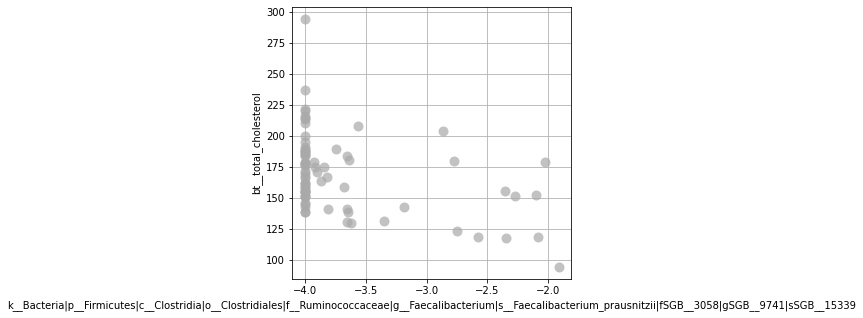

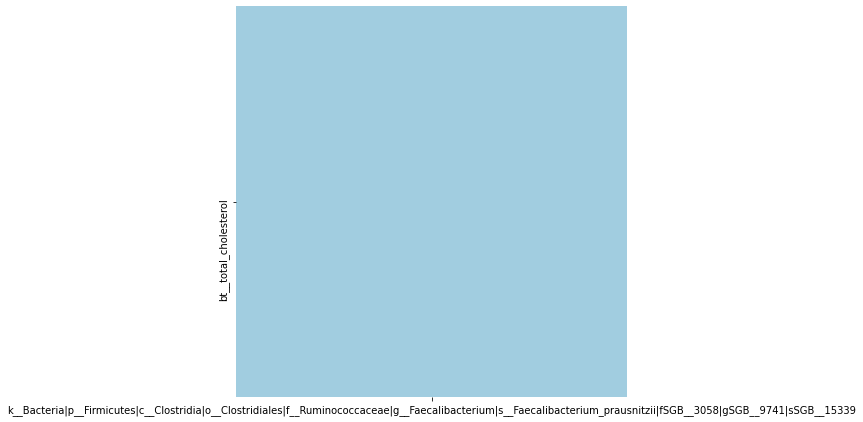

In [58]:
do_a_heatmap_and_corr_matrix(td_microbiome_species, md, 'associations_species_adults_pearson')

k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Paraprevotella|fSGB__592|gSGB__1340 0.09463364365667125
(-0.3479498423337229, 0.0025576660447748983)
SpearmanrResult(correlation=-0.27798880275474486, pvalue=0.01725235924539448)
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Paraprevotella|fSGB__592|gSGB__1340_bt__hba1c


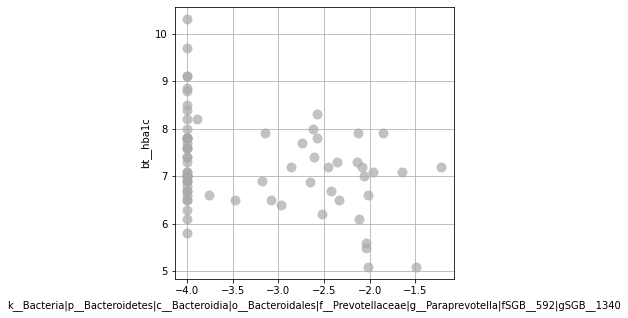

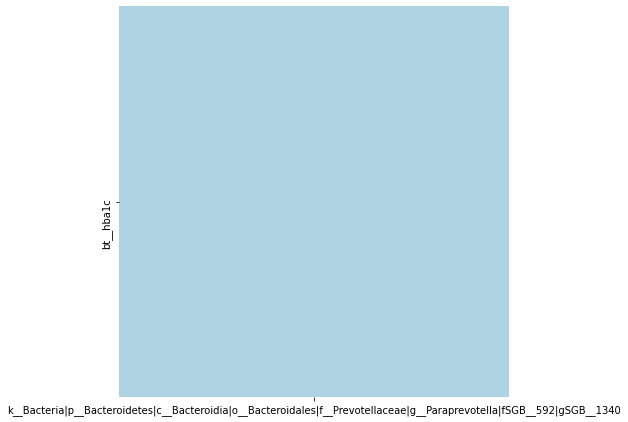

In [59]:
do_a_heatmap_and_corr_matrix(td_microbiome_genus, md, 'associations_genus_adults_pearson')

k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__no_consensus|fSGB__1421 0.01602097680791675
(-0.4028000120161682, 0.00041079427712607054)
SpearmanrResult(correlation=-0.47891394467965975, pvalue=1.8182321856391426e-05)
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__no_consensus|fSGB__1421_bt__triglycerides
k__Bacteria|p__Firmicutes|c__no_consensus|o__no_consensus|f__no_consensus|fSGB__1451 0.030858883517041615
(-0.40383475160214427, 0.0003956267117569438)
SpearmanrResult(correlation=-0.30224843951096336, pvalue=0.009351467976208007)
k__Bacteria|p__Firmicutes|c__no_consensus|o__no_consensus|f__no_consensus|fSGB__1451_bt__triglycerides
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|fSGB__592 0.09974897574622103
(-0.3479498423337229, 0.0025576660447748983)
SpearmanrResult(correlation=-0.27798880275474486, pvalue=0.01725235924539448)
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|fSGB__592_bt__hba1c
k_

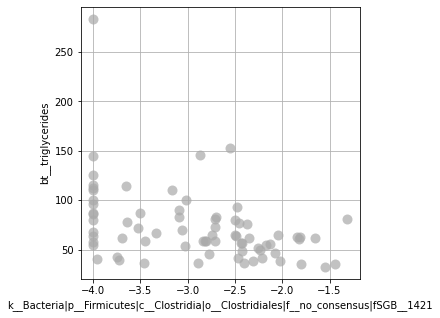

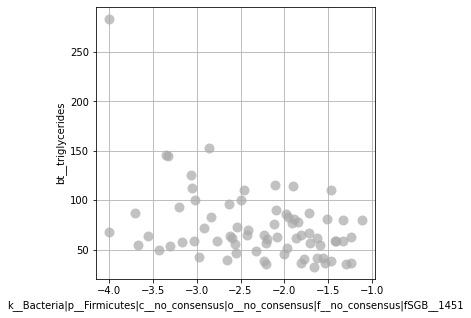

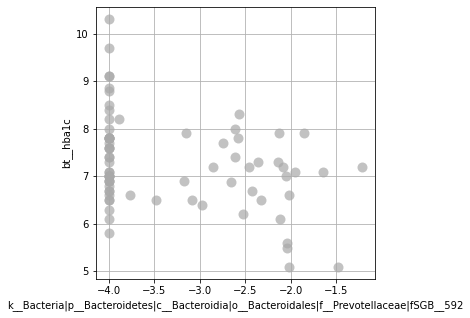

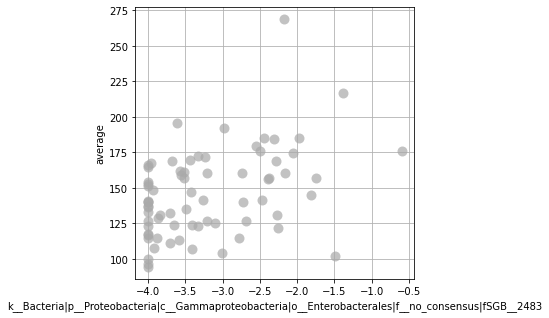

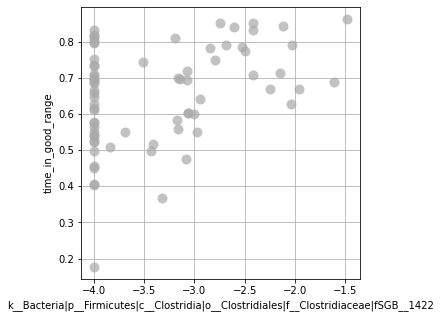

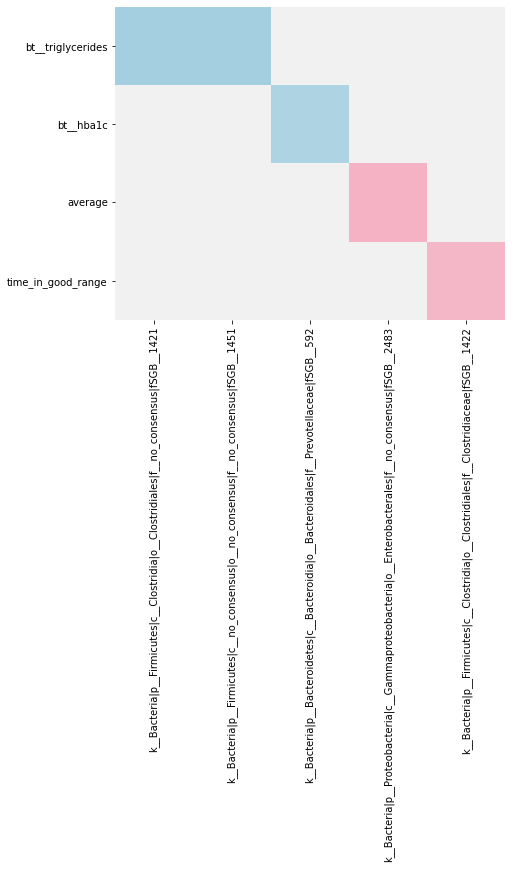

In [60]:
td_microbiome_family = all_mbl.get_data(df = 'segata_family',reg_ids=t1d_adults_reg_codes, study_ids=[6], groupby_reg='largest', take_log = True, min_col_present_frac=0.25)
td_microbiome_family = td_microbiome_family.df.join(td_microbiome_family.df_metadata[['RegistrationCode']]).set_index('RegistrationCode')

td_microbiome_family = td_microbiome_family[~td_microbiome_family.index.isin(celiac)]
td_microbiome_family = td_microbiome_family.loc[t1d_adults_reg_codes]
do_a_heatmap_and_corr_matrix(td_microbiome_family, md, 'associations_family_adults_pearson')

k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|fSGB__592
(-0.05565493882164, 0.5230102740315954)
SpearmanrResult(correlation=-0.02059636097730398, pvalue=0.8132685568314386)
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|fSGB__592_hba1c
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Paraprevotella|fSGB__592|gSGB__1340
(-0.05565493882164, 0.5230102740315954)
SpearmanrResult(correlation=-0.02059636097730398, pvalue=0.8132685568314386)
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Paraprevotella|fSGB__592|gSGB__1340_hba1c
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|fSGB__1422
(-0.01255153114507263, 0.8855486938277966)
SpearmanrResult(correlation=-0.052369752355213454, pvalue=0.5478687458142159)
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|fSGB__1422_hba1c
k__Bacteria|p__Firmicutes|c__Clostridia|o

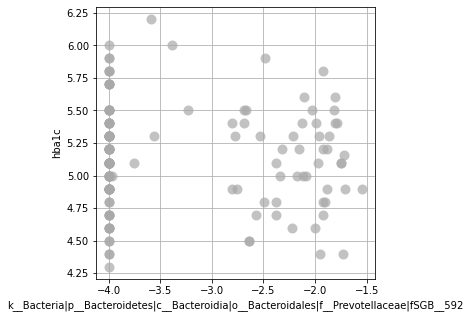

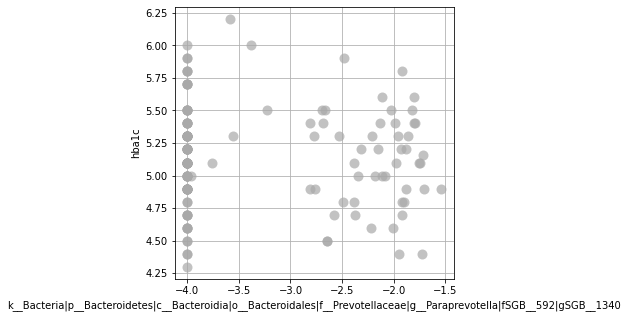

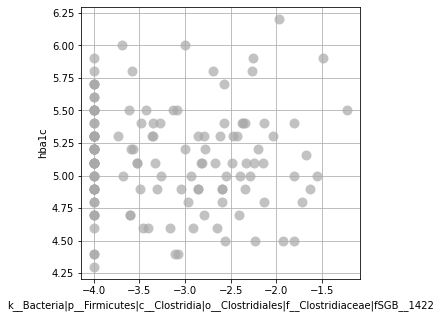

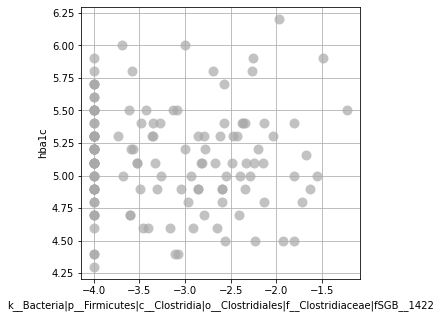

In [64]:
hbac_cols = ['k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|fSGB__592',
            'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Paraprevotella|fSGB__592|gSGB__1340',
            'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|fSGB__1422',
            'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|fSGB__1422']
            


for col in hbac_cols:
    print(col)
    do_correl_pearson(al_micr_d2[col], md_d2['bt__hba1c'], name1 = col, name2 = 'hba1c')
   # do_correl_pearson(al_micr_pnp1[col], md_pnp1['bt__hba1c'])

k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__no_consensus|fSGB__1421
(0.04950898110389023, 0.5033415385387447)
SpearmanrResult(correlation=0.03802005247682707, pvalue=0.6073852319796712)
microbiome_column_phenotype_column
k__Bacteria|p__Firmicutes|c__no_consensus|o__no_consensus|f__no_consensus|fSGB__1451
(0.16235341774509982, 0.02724791323487695)
SpearmanrResult(correlation=0.11927331528207374, pvalue=0.10586216977502691)
microbiome_column_phenotype_column


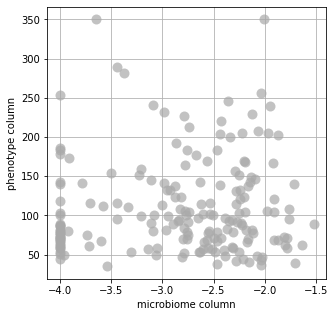

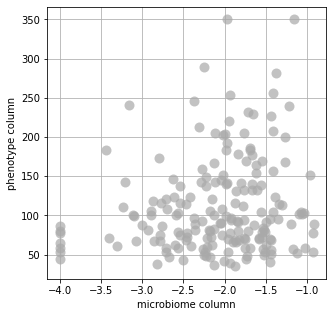

In [72]:

trig_cols = ['k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__no_consensus|fSGB__1421',
             'k__Bacteria|p__Firmicutes|c__no_consensus|o__no_consensus|f__no_consensus|fSGB__1451']
for col in trig_cols:
    print(col)
   # do_correl_pearson(td_microbiome_family[col], md['bt__triglycerides'], name1=col, name2='triglycerides')
    do_correl_pearson(al_micr_d2[col], md_d2['bt__triglycerides'].apply(lambda x: 350 if x>300 else x))


In [ ]:
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Faecalibacterium|s__Faecalibacterium_prausnitzii|fSGB__3058|gSGB__9741|sSGB__15339

k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Faecalibacterium|s__Faecalibacterium_prausnitzii|fSGB__3058|gSGB__9741|sSGB__15339
(0.0136782382085082, 0.8541888099162885)
SpearmanrResult(correlation=0.14403271495283762, pvalue=0.05174579585313292)
microbiome_column_phenotype_column


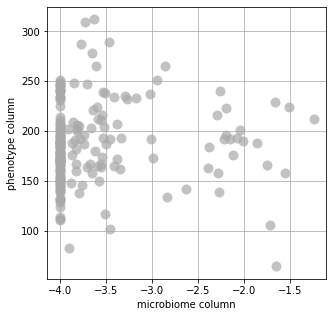

In [69]:
chol_columns = ['k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Faecalibacterium|s__Faecalibacterium_prausnitzii|fSGB__3058|gSGB__9741|sSGB__15339']
for col in chol_columns:
    print(col)
   # do_correl_pearson(td_microbiome_species[col], md['bt__total_cholesterol'], name1=col, name2='total_cholesterol')
    do_correl_pearson(al_micr_d2[col], md_d2['bt__total_cholesterol'])

In [67]:
md_d2.columns

Index(['bt__hdl_cholesterol', 'bt__glucose', 'bt__triglycerides',
       'bt__ldl_cholesterol', 'bt__hba1c', 'bt__total_cholesterol'],
      dtype='object')

In [ ]:
do_a_heatmap_and_corr_matrix(combine_by_ncbi(td_microbiome_genus), md, 'associations_genus_adults_pearson_ncbi')

In [31]:
from LabData.DataUtils.tenk_microbiome_report import MicrobiomeReportFeaturesTenk
all_mbl = GutMBLoader()
all_mb = all_mbl.get_data(df = 'segata_species', groupby_reg='largest')
all_mb = all_mb.df.join(all_mb.df_metadata[['RegistrationCode']]).set_index('RegistrationCode')
#set1 = all_mb[all_mb.index.isin(t1d_adults['SampleName'].values)]
set1 =  all_mb[all_mb.index.isin(td_microbiome_family.index)]

t1d_micr_features = MicrobiomeReportFeaturesTenk(set1).return_aggregated_features()



/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/pandas/core/frame.py:5591: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  key,


In [ ]:
control_d2_set = ['22001811620303_v0_fullrun', '22001811624815_v0_d', '22001908602331_v0_fullrun', '22001908606092_v0_fullrun', 'sample_22001811623966_v0_fullrun', '22001904611784_v0_fullrun', '22001811620980_v0_fullrun', '22001811625263_v0_d', '22001904601366_v0_fullrun', '22001904604665_v0_fullrun', '22001908603832_v0_fullrun', '22001908606793_v0_fullrun', '22001908611724_v0_fullrun', '22001908612813_v0_fullrun', '22001908614033_v0_fullrun', 'sample_22001908606102_v0_fullrun', '22001904602877_v0_fullrun', '22001904611222_v0_fullrun', '22001910715224_v0_fullrun', '22001808560026_v0_d', '22001811620492_v0_d', '22001811622761_v0_fullrun', '22001811624022_v0_fullrun', '22001901560891_v0_fullrun', '22001901564392_v0_fullrun', '22001901565263_v0_fullrun', '22001904600571_v0_fullrun', '22001904612392_v0_fullrun', '22001901560227_v0_fullrun', '22001901564387_v0_fullrun', '22001904611657_v0_fullrun', '22001908601637_v0_fullrun', '22001908605007_v0_fullrun', '22001908606869_v0_fullrun', '22001807541046_v0_fullrun', '22001811621637_v0_fullrun', '22001811623933_v0_d', '22001901560597_v0_fullrun', '22001901562055_v0_fullrun', '22001901565309_v0_fullrun', '22001904600681_v0_fullrun', '22001904603238_v0_fullrun', '22001904603929_v0_fullrun', '22001904611847_v0_fullrun', '22001904612932_v0_fullrun', '22001904613662_v0_fullrun', '22001908603456_v0_fullrun', '22001908604130_v0_fullrun', '22001908606445_v0_fullrun', '22001908610765_v0_fullrun', '22001908611706_v0_fullrun', '22001908612065_v0_fullrun', '22001908612144_v0_fullrun', '22001908613305_v0_fullrun', '22001908613496_v0_fullrun', '22001908614158_v0_fullrun', '22001910702306_v0_fullrun', '22001910704606_v0_fullrun', 'sample_22001811623249_v0_fullrun', 'sample_22001901561813_v0_fullrun', 'sample_22001901562094_v0_fullrun', '22001808562827_v0_fullrun', '22001808562866_v0_fullrun', '22001811620733_v0_fullrun', '22001811621106_v0_d', '22001811621838_v0_fullrun', '22001811622376_v0_d', '22001811622462_v0_fullrun', '22001811622492_v0_fullrun', '22001811623256_v0_d', '22001904610821_v0_fullrun', '22001904611264_v0_fullrun', 'sample_22001904604342_v0_fullrun', 'sample_22001908600603_v0_fullrun', 'sample_22001908604845_v0_fullrun', '22001806580438_v0_fullrun', '22001901560193_v0_fullrun', '22001901561117_v0_fullrun', '22001901561311_v0_fullrun', '22001901563665_v0_fullrun', '22001901563890_v0_fullrun', '22001904600820_v0_fullrun', '22001904603817_v0_fullrun', '22001904603960_v0_fullrun', '22001904604072_v0_fullrun', '22001904604539_v0_fullrun', '22001904610319_v0_fullrun', '22001904612434_v0_fullrun', '22001904612637_v0_fullrun', '22001904612840_v0_fullrun', '22001811622387_v0_d', '22001811623708_v0_fullrun', '22001811624230_v0_fullrun', '22001901561619_v0_fullrun', '22001904600472_v0_fullrun', '22001904602617_v0_fullrun', '22001904610307_v0_fullrun', '22001904611650_v0_fullrun', '22001904614418_v0_fullrun', '22001908600997_v0_fullrun', '22001811620037_v0_fullrun', '22001811620330_v0_fullrun', '22001811621578_v0_fullrun', '22001811622073_v0_fullrun', '22001811622918_v0_fullrun', '22001811622923_v0_fullrun', '22001811623327_v0_fullrun', '22001811623478_v0_fullrun', '22001811625221_v0_d', '22001811624737_v0_d', '22001908601539_v0_fullrun', '22001908602537_v0_fullrun', '22001908612664_v0_fullrun', '22001908614653_v0_fullrun', '22001910715030_v0_fullrun', '22001804573155_v0_fullrun', '22001811620283_v0_fullrun', '22001811621042_v0_fullrun', '22001811621104_v0_d', '22001811621126_v0_fullrun', '22001811622284_v0_fullrun', '22001807542048_v0_d', '22001808563073_v0_fullrun', '22001811620089_v0_fullrun', '22001811620242_v0_fullrun', '22001807540846_v0_fullrun', '22001808560174_v0_fullrun', '22001810500201_v0_fullrun', '22001811620119_v0_d', '22001811620422_v0_fullrun', '22001811622172_v0_d', '22001811622629_v0_fullrun', '22001811624075_v0_fullrun', '22001811624824_v0_fullrun', '22001901561554_v0_fullrun', '22001901562201_v0_fullrun', '22001901562437_v0_fullrun', '22001808560712_v0_fullrun', '22001901561604_v0_fullrun', '22001901563041_v0_fullrun', '22001904614046_v0_fullrun', '22001904614126_v0_fullrun', '22001904614845_v0_fullrun', '22001908605604_v0_fullrun', '22001908610064_v0_fullrun', '22001805620384_v0_fullrun', '22001808563110_v0_fullrun', '22001808564027_v0_fullrun', '22001811620775_v0_fullrun', '22001811621310_v0_fullrun', '22001811621530_v0_fullrun', '22001808564045_v0_d', '22001901563654_v0_fullrun', '22001901564961_v0_fullrun', '22001908602945_v0_fullrun', '22001804571742_v0_fullrun', '22001806580283_v0_d', '22001808561540_v0_d', '22001808561851_v0_fullrun', '22001810502134_v0_fullrun', '22001811620979_v0_fullrun', '22001811621296_v0_d', '22001811622036_v0_fullrun', '22001811622224_v0_fullrun', '22001808560242_v0_d', '22001811620446_v0_fullrun', '22001811623169_v0_d', '22001811624749_v0_d', '22001901560079_v0_fullrun', '22001901560137_v0_fullrun', '22001811620810_v0_fullrun', '22001811620838_v0_fullrun', '22001811621337_v0_fullrun', '22001811621675_v0_d', '22001811622217_v0_fullrun', '22001811623831_v0_d', '22001808563752_v0_fullrun', '22001811621679_v0_d', '22001811622826_v0_fullrun', '22001811624374_v0_d', '22001804572506_v0_fullrun', '22001811620846_v0_d', '22001811621774_v0_d', '22001811622924_v0_d', '22001811623014_v0_d', '22001811623530_v0_fullrun', '22001807541949_v0_fullrun', '22001811620152_v0_fullrun', '22001811621901_v0_fullrun', '22001811622856_v0_fullrun', '1711522133_v0_fullrun', '22001806580152_v0_fullrun', '22001808560349_v0_d', '22001808562718_v0_fullrun', '22001811620708_v0_fullrun', '22001811621293_v0_d', '22001808561425_v0_fullrun', '22001808563180_v0_fullrun', '22001811621168_v0_d', '22001811622065_v0_fullrun', '22001807540696_v0_fullrun', '22001808560217_v0_d', '22001808563623_v0_fullrun', '22001808561987_v0_d', '22001808562605_v0_fullrun', '22001808563476_v0_d', '22001811620403_v0_fullrun', '22001811620465_v0_d', '22001808561161_v0_fullrun', '22001811620116_v0_fullrun', '1808612517_v0_fullrun', '22001811620948_v0_fullrun', '22001811622346_v0_fullrun', '22001811622869_v0_d', '22001811623422_v0_fullrun', '22001811623465_v0_d', '22001805621063_v0_d', '22001807540014_v0_d', '22001808562141_v0_fullrun', '22001811623015_v0_fullrun', '1711522955_v0_d', '22001807542913_v0_fullrun', '22001808560301_v0_fullrun', '22001811620061_v0_fullrun', '22001811620130_v0_fullrun', '22001811621069_v0_fullrun', '1711521467_v0_d', '22001803510227_v0_fullrun', '22001806581160_v0_fullrun', '22001808563255_v0_fullrun', '22001805620410_v0_d', '22001808560099_v0_d', '22001808560227_v0_fullrun', '22001811620765_v0_fullrun', '22001811621275_v0_d', '22001811624330_v0_d', '22001804571128_v0_d', '22001808561065_v0_d', '22001811624028_v0_fullrun', '22001811624282_v0_fullrun', '22001806581159_v0_fullrun', '22001807540071_v0_fullrun', '22001807540414_v0_fullrun', '22001807540799_v0_fullrun', '22001807542936_v0_fullrun', '22001808563244_v0_fullrun', '22001804571187_v0_fullrun', '22001804572542_v0_fullrun', '22001807540381_v0_fullrun', '22001808563292_v0_fullrun', '22001804572166_v0_d', '22001806580067_v0_d', '22001807540900_v0_fullrun', '22001811620312_v0_fullrun', '22001811620686_v0_fullrun', '22001811620877_v0_fullrun', '1711520771_v0_fullrun', '22001804571413_v0_fullrun', '22001804573900_v0_fullrun', '22001806581783_v0_fullrun', '22001803510797_v0_fullrun', '22001808560172_v0_fullrun', '22001808561013_v0_fullrun', '22001811621289_v0_d', '22001811621934_v0_d', '22001804572591_v0_fullrun', '22001807540972_v0_fullrun', '22001807542904_v0_d', '22001808561052_v0_fullrun', '22001808562734_v0_fullrun', '22001811620017_v0_d', '22001808560735_v0_fullrun', '22001808563585_v0_fullrun', '22001808563989_v0_fullrun', '22001811620010_v0_fullrun', '22001806580835_v0_d', '22001807500438_v0_d', '22001807543042_v0_d', '22001804573508_v0_fullrun', '22001808561641_v0_fullrun', '1905642166_v0_fullrun', '22001807500843_v0_fullrun', '22001807540141_v0_fullrun', '22001807540365_v0_fullrun', '22001808560819_v0_fullrun', '1711522224_v0_fullrun', '22001806580334_v0_fullrun', '22001808560933_v0_d', '22001811622049_v0_d', '22001811624001_v0_d', '22001805620387_v0_fullrun', '22001807540143_v0_d', '22001811620322_v0_fullrun', '22001811620659_v0_fullrun', '22001811621099_v0_fullrun', '22001811622472_v0_d', '22001806581170_v0_d', '22001807540380_v0_fullrun', '22001808560658_v0_fullrun', '22001808560885_v0_d', '22001804571030_v0_fullrun', '22001804573446_v0_fullrun', '22001808561468_v0_fullrun', '22001808562956_v0_fullrun', '22001811620245_v0_d', '22001806581725_v0_fullrun', '22001808561001_v0_d', '22001808562576_v0_fullrun', '22001811620447_v0_fullrun', '22001811621380_v0_d', '22001811621791_v0_d', '22001807540408_v0_fullrun', '22001808560233_v0_fullrun', '22001811620015_v0_fullrun', '22001811621123_v0_d', '22001806514601_v0_fullrun', '22001806581146_v0_fullrun', '22001808560344_v0_d', '22001806514624_v0_fullrun', '22001811620996_v0_d', '22001808562584_v0_fullrun', '22001811620042_v0_fullrun', '22001811620438_v0_fullrun', '22001807540516_v0_fullrun', '22001811620546_v0_d']

In [ ]:
all_mb.df_metadata[all_mb.df_metadata.index.isin(control_d2_set)]['Date'].sort_values()

In [ ]:
print(len(control_d2_set))

In [ ]:
import os
folder = '/net/mraid08/export/genie/LabData/Data/MBPipeline/NovaSeq/tmp2/UNT'
folder_clalit =  '/net/mraid08/export/genie/LabData/Data/MBPipeline/ClalitD2/tmp2/UNT'

all_mbl = GutMBLoader()
all_mb = all_mbl.get_data(df = 'segata_species', study_ids=[6], )
other_samps = all_mb.df_metadata.index

names = []

        
for fastq_file in other_samps:
    if os.path.exists(os.path.join(folder,fastq_file+'.fastq.gz' )):
        names+=[os.path.join(folder,fastq_file+'.fastq.gz' )]
    elif os.path.exists(os.path.join(folder_clalit,fastq_file+'.fastq.gz' )):
         names+=[os.path.join(folder_clalit,fastq_file+'.fastq.gz' )]
    else:
        print('missing', fastq_file)
        
    print(len(names))
import pickle
with open('/net/mraid08/export/genie/LabData/Data/StudySpecificData/T1D/sample_pathes_t1d.pkl', 'wb') as f:
    pickle.dump(names, f)

In [ ]:
import os
folder = '/net/mraid08/export/genie/LabData/Data/MBPipeline/NovaSeq/tmp2/UNT'
folder_clalit =  '/net/mraid08/export/genie/LabData/Data/MBPipeline/ClalitD2/tmp2/UNT'

all_mbl = GutMBLoader()
all_mb = all_mbl.get_data(df = 'segata_species', study_ids=[6, 19], )
other_samps = all_mb.df_metadata.index

names = []


for fastq_file in control_d2_set:
    if os.path.exists(os.path.join(folder,fastq_file+'.fastq.gz' )):
        names+=[os.path.join(folder,fastq_file+'.fastq.gz' )]
    elif os.path.exists(os.path.join(folder_clalit,fastq_file+'.fastq.gz' )):
         names+=[os.path.join(folder_clalit,fastq_file+'.fastq.gz' )]
    else:
        print('missing', fastq_file)
        
for fastq_file in other_samps:
    if os.path.exists(os.path.join(folder,fastq_file+'.fastq.gz' )):
        names+=[os.path.join(folder,fastq_file+'.fastq.gz' )]
    elif os.path.exists(os.path.join(folder_clalit,fastq_file+'.fastq.gz' )):
         names+=[os.path.join(folder_clalit,fastq_file+'.fastq.gz' )]
    else:
        print('missing', fastq_file)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind
from DataLoaders.SubjectLoader import SubjectLoader

from DataLoaders.GutMBLoader import GutMBLoader

from DataLoaders.CGMLoader import CGMLoader

In [34]:
all_mbl = GutMBLoader()
all_mb = all_mbl.get_data(df = 'segata_species', study_ids=[1000,6], take_log=True, min_col_present_frac=0.2)
all_mb_md = all_mb.df_metadata.set_index('RegistrationCode')
all_mb_md.head(3)

all_mb_md.loc[all_mb_md.index.isin(dates.index), 'Date'] = dates['Date']
#dates

In [ ]:
pnp1_mbl = GutMBLoader()
pnp1_mb = pnp1_mbl.get_data(df = 'segata_species', study_ids=[1], take_log=True, min_col_present_frac=0.2)
pnp1_mb_md = pnp1_mb.df_metadata.set_index('RegistrationCode')
pnp1_mb_md.head(3)

#pnp1_mb_md.loc[pnp1_mb_md.index.isin(dates.index), 'Date'] = dates['Date']

In [ ]:
mbl = GutMBLoader()

t1d_mbl = mbl.get_data(df='segata_species', study_ids=6)

print(t1d_mbl.df.shape)

In [ ]:
from DataLoaders.BodyMeasuresLoader import BodyMeasuresLoader

bml = BodyMeasuresLoader()

bmld = bml.get_data(study_ids=6)

bmld.df[bmld.df.index.get_level_values(0).isin(t1d_mbl.df_metadata['RegistrationCode'].values)]

In [ ]:
t1d_reg_codes = t1d_mbl.df_metadata['RegistrationCode'].values
len(t1d_reg_codes)

In [39]:
all_mb_md = all_mb.df_metadata
#all_mb_md = all_mb_md[~all_mb_md.index.isin(['2565375FD3314_v0_fullrun'])]
all_mb_md = all_mb_md.reset_index().set_index('RegistrationCode')
all_mb_md.loc[all_mb_md.index.isin(dates.index), 'Date'] = dates['Date']

all_mb_md['StorageDT'].dropna()

RegistrationCode
2010578    2018-03-18 09:00:00
2011588    2018-03-18 09:00:00
2051853    2018-03-18 09:00:00
2069248    2018-03-18 09:00:00
2074520    2018-03-18 09:00:00
                  ...         
2946283    2018-03-18 09:00:00
2948637    2018-03-18 09:00:00
2953310    2018-03-18 09:00:00
2990383    2018-03-18 09:00:00
2998285    2018-03-18 09:00:00
Name: StorageDT, Length: 125, dtype: object

In [40]:
t2d_mbmd = all_mb_md.dropna(subset=['StorageDT'])

In [ ]:
len(set(t1d_adults_reg_codes))

In [63]:
from DataLoaders.BloodTestsLoader import BloodTestsLoader
from DataLoaders.BodyMeasuresLoader import BodyMeasuresLoader


btl = BloodTestsLoader()

btld = btl.get_data(groupby_reg='first').df.reset_index().set_index('RegistrationCode')


btld = btld.groupby(btld.index).first()

ml = BodyMeasuresLoader()

mld = ml.get_data(groupby_reg='first').df.reset_index().set_index('RegistrationCode')

mld = mld.groupby(mld.index).first()


control_d2_healthy = all_mb_md[all_mb_md.index.isin(control_d2_samples)]
md = pd.concat([all_mb_md.set_index('RegistrationCode')[['age', 'gender']], mld[['weight', 'bmi']], btld[['bt__hba1c']]]) 

md = md.groupby(md.index).first()

compare_2_groups(md, t1d_adults_reg_codes, control_d2_healthy['RegistrationCode'].values, group1_name='t1d adults', group2_name='control adults')[0].round(2)


,t1d adults mean,t1d adults std,control adults mean,control adults std,ttest_pvalue,mw_pvalue
number of samples,74,NaN,296,NaN,NaN,NaN
age,32.256757,14.426062,32.77027,13.904807,0.778085,0.37
gender,0.378378,0.488293,0.266892,0.443084,0.058737,0.06
weight,71.021622,12.810382,71.787162,14.898253,0.684982,0.63
bmi,25.092486,4.035611,25.493998,4.25317,0.463634,0.38
bt__hba1c,7.264658,0.962392,5.141493,0.383914,0.0,0.00


In [65]:
compare_2_groups(md, t1d_adults_reg_codes, control_d2_healthy['RegistrationCode'].values, group1_name='t1d adults', group2_name='control adults')[0].round(2).to_csv(os.path.join(global_path, 'chort_cpmparison.csv'))

In [66]:
len(control_d2_healthy['RegistrationCode'].values)

296

In [67]:
old_t2d = md.loc[control_d2_healthy['RegistrationCode'].values]['age'].sort_values().tail(12)

In [68]:
compare_2_groups(md, t1d_adults_reg_codes, control_d2_healthy['RegistrationCode'].values, group1_name='t1d adults', group2_name='control adults')[0].round(2)

,t1d adults mean,t1d adults std,control adults mean,control adults std,ttest_pvalue,mw_pvalue
number of samples,74,NaN,296,NaN,NaN,NaN
age,32.256757,14.426062,32.77027,13.904807,0.778085,0.37
gender,0.378378,0.488293,0.266892,0.443084,0.058737,0.06
weight,71.021622,12.810382,71.787162,14.898253,0.684982,0.63
bmi,25.092486,4.035611,25.493998,4.25317,0.463634,0.38
bt__hba1c,7.264658,0.962392,5.141493,0.383914,0.0,0.00


In [105]:
from LabData.DataUtils.tenk_microbiome_report import MicrobiomeReportFeaturesTenk
all_mbl = GutMBLoader()
all_mb = all_mbl.get_data(df = 'segata_species')
all_mb = all_mb.df.join(all_mb.df_metadata[['RegistrationCode']]).set_index('RegistrationCode')
#set1 = all_mb[all_mb.index.isin(t1d_adults['SampleName'].values)]
set1 =  all_mb[all_mb.index.isin(md.index)]

t1d_micr_features = MicrobiomeReportFeaturesTenk(set1).return_aggregated_features()



In [81]:
all_mb = all_mbl.get_data(df = 'segata_species', study_ids=[6,1000], min_col_present_frac=0.2)
all_mb = all_mb.df
all_mb.head(3)
set1_species = all_mb[all_mb.index.isin(t2d_samples)]

set2_species = all_mb[all_mb.index.isin(control_d2_samples)]

all_mb = all_mbl.get_data(df = 'segata_genus', study_ids=[6,1000], min_col_present_frac=0.2)
all_mb = all_mb.df
all_mb.head(3)
set1_genus = all_mb[all_mb.index.isin(t2d_samples)]

set2_genus = all_mb[all_mb.index.isin(control_d2_samples)]
all_mb = all_mbl.get_data(df = 'segata_family', study_ids=[6,1000], min_col_present_frac=0.2)
all_mb = all_mb.df
all_mb.head(3)
set1_family = all_mb[all_mb.index.isin(t2d_samples)]

set2_family = all_mb[all_mb.index.isin(control_d2_samples)]

set1_all = set1_species.join(set1_genus).join(set1_family)
set1_all['group'] = '111'
set2_all = set2_species.join(set2_genus).join(set2_family)
set2_all['group'] = '222'

set_both_all = set2_all.append(set1_all)
set_both_all = set_both_all.reset_index()
del set_both_all['SampleName']

set_both_all.T.to_csv('/net/mraid08/export/genie/LabData/Data/StudySpecificData/T1D//microbiome//X1_y_1_T_abund.csv', sep='\t')




In [82]:
len(set(set1_all.index))

74

In [83]:
all_species_combined = set1_all.join(all_mbl.get_data(df = 'segata_family', groupby_reg='largest', study_ids=[6], min_col_present_frac=0.2).df_metadata['RegistrationCode']).set_index('RegistrationCode')

In [84]:
all_species_combined = all_species_combined[[col for col in all_species_combined.columns 
                                            if 'unknown' not in col and 'group' not in col]]

all_species_combined = all_species_combined[all_species_combined.index.isin(reg_ids)]

In [85]:
all_species_combined_grouped = pd.DataFrame()
for col_new in set([c.split('SGB')[0] for c in all_species_combined.columns]):
    if col_new!='group':
        all_species_combined_grouped[col_new[:-2]] = all_species_combined[[col for col in all_species_combined.columns if col_new in col]].sum(axis=1)
all_species_combined_grouped

,k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__no_consensus,k__Bacteria|p__Firmicutes|c__Firmicutes_unclassified|o__Firmicutes_unclassified|f__Firmicutes_unclassified,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Tannerellaceae|g__Parabacteroides|s__Parabacteroides_merdae,k__Bacteria|p__Firmicutes|c__Firmicutes_unclassified|o__Firmicutes_unclassified|f__Firmicutes_unclassified|g__Firmicutes_unclassified|s__Firmicutes_bacterium_CAG_102,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Roseburia,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae,k__Bacteria|p__Firmicutes|c__Firmicutes_unclassified|o__Firmicutes_unclassified|f__Firmicutes_unclassified|g__Firmicutes_unclassified,k__Bacteria|p__Firmicutes|c__no_consensus|o__no_consensus|f__no_consensus,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Odoribacteraceae|g__Butyricimonas|s__Butyricimonas_sp_An62,...,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Odoribacteraceae|g__Odoribacter,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_unclassified|g__Intestinimonas|s__Intestinimonas_butyriciproducens,k__Bacteria|p__Firmicutes|c__Firmicutes_unclassified|o__Firmicutes_unclassified|f__Firmicutes_unclassified|g__Firmicutes_unclassified|s__Firmicutes_bacterium_CAG_110,k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Sutterellaceae,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Paraprevotella|s__Paraprevotella_xylaniphila,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_sp_CAG_274,k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Coriobacteriales|f__no_consensus,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_finegoldii,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_bifidum
RegistrationCode,,,,,,,,,,,,,,,,,,,,,
2011588,0.000219,0.042903,0.000566,0.000100,0.000770,0.034160,0.0001,0.041055,0.107476,0.000385,...,0.003982,0.000164,0.000100,0.000200,0.0001,0.00010,0.000100,0.000100,0.010421,0.000100
2117136,0.024119,0.030037,0.001340,0.000100,0.000210,0.012693,0.0001,0.073543,0.137110,0.000135,...,0.006586,0.000100,0.000100,0.000200,0.0001,0.00010,0.000100,0.000100,0.019822,0.000100
2130667,0.002328,0.014576,0.000480,0.000104,0.000673,0.004427,0.0001,0.004567,0.050006,0.000155,...,0.000136,0.000100,0.000100,0.012244,0.0001,0.00010,0.000100,0.000100,0.001021,0.000100
2149698,0.006429,0.029680,0.000200,0.000165,0.000100,0.036160,0.0001,0.013965,0.070997,0.000100,...,0.000100,0.000100,0.000100,0.000200,0.0001,0.00010,0.000410,0.000100,0.015033,0.000100
2152850,0.001307,0.036632,0.000200,0.016362,0.000185,0.047391,0.0001,0.007955,0.040626,0.000100,...,0.003542,0.000100,0.000100,0.010463,0.0001,0.00010,0.000100,0.000100,0.002588,0.000100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2942935,0.008123,0.095858,0.000469,0.000100,0.000100,0.031636,0.0001,0.006332,0.057058,0.001008,...,0.003663,0.000100,0.000100,0.011911,0.0001,0.00049,0.002127,0.000100,0.000500,0.002554
2946283,0.014694,0.019058,0.000621,0.014189,0.000525,0.026448,0.0001,0.016124,0.070102,0.000214,...,0.002128,0.000177,0.000679,0.014387,0.0001,0.00010,0.000839,0.003820,0.002298,0.002462
2953310,0.000567,0.062165,0.000980,0.003781,0.004529,0.006703,0.0001,0.043200,0.185557,0.000254,...,0.003160,0.000132,0.000100,0.007782,0.0001,0.00010,0.000100,0.000691,0.010532,0.000100


In [87]:
set_both_all_known = set_both_all[[col for col in set_both_all.columns if 'unknown' not in col]]

set_both_all_known.T.to_csv('/net/mraid08/export/genie/LabData/Data/StudySpecificData/T1D//microbiome//X1_y_1_T_abund_known.csv', sep='\t')


In [88]:
set_grouped = pd.DataFrame()
for col_new in set([c.split('SGB')[0] for c in set_both_all_known.columns]):
    if col_new!='group':
        set_grouped[col_new[:-2]] = set_both_all_known[[col for col in set_both_all_known.columns if col_new in col]].sum(axis=1)
set_grouped['group'] =    set_both_all_known['group']   
set_grouped.T.to_csv('/net/mraid08/export/genie/LabData/Data/StudySpecificData/T1D//microbiome//X1_y_1_T_abund_known_grouped.csv', sep='\t')
    

In [89]:
set_grouped['group']

0      222
1      222
2      222
3      222
4      222
      ... 
365    111
366    111
367    111
368    111
369    111
Name: group, Length: 370, dtype: object

/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: 

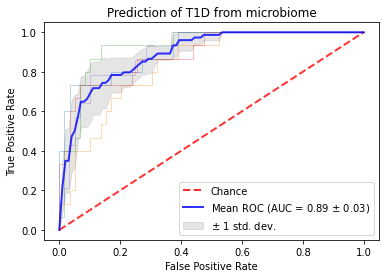

In [101]:
plt.rcParams['figure.figsize'] = [6, 4]
all_mbl = GutMBLoader()
all_mb = all_mbl.get_data(df = 'segata_species', study_ids=[1000,6], take_log=True, min_col_present_frac=0.1)
all_mb = all_mb.df
all_mb.head(3)
set1 = all_mb[all_mb.index.isin(t2d_samples)]

set2 = all_mb[all_mb.index.isin(control_d2_samples)]






from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=104)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc
from scipy import interp
import numpy as np

set1['is t1d'] = 1

set2['is t1d'] = 0

X = set1.append(set2).fillna(-4)

y = X.reset_index()['is t1d']

#y = y.

del X['is t1d']

#class_weight = dict({0:1.9, 1:35})
#classifier = RandomForestClassifier()
classifier = GradientBoostingClassifier(n_estimators = 2000,learning_rate=.01,max_depth=6,max_features=1,min_samples_leaf=10)
#classifier = svm.SVC(kernel='linear', probability=True,
#                     random_state=random_state)
#
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
y_test_all = []
y_predict_all = []
y_pred = []
y_true = []
trhresh_all = []

i = 0
for i, (train, test) in enumerate(cv.split(X, y)):
    fitted = classifier.fit(X.iloc[train], y.iloc[train])
    probas_ = fitted.predict_proba(X.iloc[test])

    fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
    trhresh_all+=[thresholds]
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3)
           #  label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Prediction of T1D from microbiome')
plt.legend(loc="lower right")
plt.savefig('/net/mraid08/export/genie/LabData/Data/StudySpecificData/T1D//microbiome//predictor_t1d_hc.jpg', dpi=800)

/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid

<AxesSubplot:xlabel='PC1, 7.7%', ylabel='PC2, 4.4 %'>

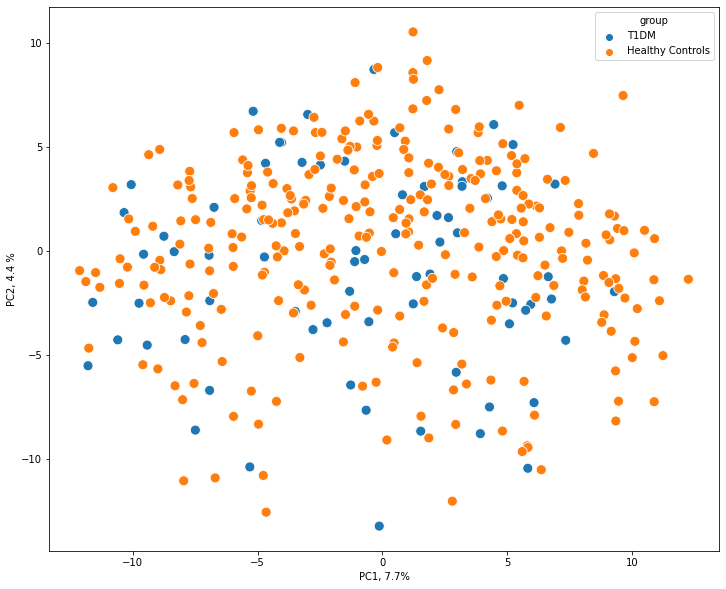

In [106]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns
set1['is t1d'] = 'T1DM'

set2['is t1d'] = 'Healthy Controls'

X = set1.append(set2).fillna(-4)

y = X.reset_index()['is t1d']

#y = y.

del X['is t1d']

X_scaled = StandardScaler().fit_transform(X)
X_scaled[:5]
features = X_scaled.T
cov_matrix = np.cov(features)
cov_matrix[:5]
values, vectors = np.linalg.eig(cov_matrix)
values[:5]
explained_variances = []
for i in range(len(values)):
    explained_variances.append(values[i] / np.sum(values))
    
    
projected_1 = X_scaled.dot(vectors.T[0])
projected_2 = X_scaled.dot(vectors.T[1])
res = pd.DataFrame(projected_1, columns=['PC1, 7.7%'])
res['PC2, 4.4 %'] = projected_2
res['group'] = y
res.head()


plt.figure(figsize=(12, 10))
sns.scatterplot(res['PC1, 7.7%'], res['PC2, 4.4 %'], hue=res['group'], s=100)

In [105]:
explained_variances
#*100

[(0.07728628715346779+1.7392263076122144e-35j),
 (0.04401666906165901+9.905372819046467e-36j),
 (0.03357894020333644+7.556499132557921e-36j),
 (0.02123361394420527+4.7783457243988376e-36j),
 (0.01934423275206119+4.353165321055155e-36j),
 (0.015961118173396082+3.591839852644844e-36j),
 (0.01459724616224245+3.284918383212094e-36j),
 (0.012582073523911417+2.83143026830161e-36j),
 (0.011247637375401421+2.5311329528530482e-36j),
 (0.010825651337025143+2.4361705414835235e-36j),
 (0.00966584966110964+2.1751724187040586e-36j),
 (0.009515057860826081+2.1412387060514376e-36j),
 (0.009464166687856414+2.1297863164860893e-36j),
 (0.008842222695041056+1.989825995709143e-36j),
 (0.008647666637089753+1.946043712103991e-36j),
 (0.008457498702172928+1.9032489179104408e-36j),
 (0.00821349379577072+1.8483388209150344e-36j),
 (0.008107907753033586+1.8245780698156265e-36j),
 (0.007950945082101035+1.789255683833119e-36j),
 (0.007920130173056289+1.78232119358249e-36j),
 (0.007643252101637305+1.720013422883581

In [ ]:
import pandas as pd
import numpy as np
from sklearn import manifold
import scipy.stats
import matplotlib.pyplot as plt
import itertools
from scipy.spatial import distance
from scipy.spatial.distance import braycurtis

def BrayCurtis(X):

    X = np.array(X)
    n_samples = X.shape[0] 
    n_distance = int(n_samples * (n_samples - 1) / 2)
    d_array = np.zeros((n_distance))
    for i, (idx1, idx2) in enumerate(itertools.combinations(range(n_samples),2)):
        d_array[i] = braycurtis(X[idx1], X[idx2])    
    return squareform(d_array)

def executePCoA(data, distance_metric='BrayCurtis', drawBiplot=False, n_arrows=False, groupfile=False):    
    matrix = data.values
    n_features, n_samples = matrix.shape
    print(n_features,'features, ',n_samples,'samples')
    

    if distance_metric == 'BrayCurtis':
        distance_matrix = distance.squareform(distance.pdist(matrix.T, metric="braycurtis"))

 
  # execute PCoA
    mds = manifold.MDS(n_components=2, max_iter=3000, dissimilarity="precomputed", n_jobs=1)
    positions = mds.fit(distance_matrix).embedding_
    positions_with_sampleIndex = pd.DataFrame(positions, index=data.columns)
    
    # General settings of the canvas
    fig = plt.figure(figsize=(12,12))
    ax = fig.gca()
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_position(('data',0))
    ax.spines['left'].set_position(('data',0))
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
#    ax.set_xlim(-0.02,0.02)
#    ax.set_ylim(-0.02,0.02)
    
  
    # draw plots using colors if samples are binned into groups
    if True:
        group_names = []
        group2sample = {}
        df = groupfile
        for sample in df.index:
            # Use the value of second column (1) as a grouping category.
            group = df.loc[sample]
            if group in group2sample:
                group2sample[group].append(sample)
            else:
                group2sample[group] = [sample]
                group_names.append(group)
        colors = itertools.cycle(['r','g','b','c','m','y','k'])
        markers = itertools.cycle(['o','^','s','*','x'])
        for i,current_group in enumerate(group_names):
            if len(group2sample[current_group]) == 0:
                continue
            ax.scatter(positions_with_sampleIndex.loc[group2sample[current_group],0],
                       positions_with_sampleIndex.loc[group2sample[current_group],1],
                       s=100, marker=next(markers), color=next(colors), label='%s'%current_group)
        plt.legend(bbox_to_anchor=(0., 1.01, 1., 1.01), loc=3, ncol=6, mode="expand", borderaxespad=0.)
    else:
        for i,sample_name in enumerate(data.columns):
            ax.annotate(sample_name, xy=(positions[i,0],positions[i,1]), xytext=(5,5), textcoords='offset points', color='k', fontsize=16)
        ax.scatter(positions[:,0], positions[:,1], c='k', s=50)
    
    x_label = 'PCo1'
    y_label = 'PCo2'
 #   ax.annotate(x_label, xy=(0.0, -1.0), xytext=(0.0,-40.0), textcoords='offset points', ha='center', color='k', fontsize=18)
#    ax.annotate(y_label, xy=(-1.0, 0.0), xytext=(-40.0,0.0), textcoords='offset points', ha='center', color='k', fontsize=18, rotation=90)
    plt.show()

set1['is t1d'] = 'T1DM'

set2['is t1d'] = 'Healthy Controls'

X = set1.append(set2).fillna(0.0001)

y = X['is t1d']

#y = y.

del X['is t1d']


X_t = X[[col for col in X.columns if X[col].quantile(0.7)>0.0002]].T.reset_index().fillna(0.0001)

X_t['sp'] = X_t['index'].apply(lambda x: x.split('|fSGB')[0])

del X_t['index']

X_t = X_t.groupby(['sp']).sum()
#executePCoA(X.apply(lambda x: np.log10(x)).T, groupfile = y)

executePCoA(X_t, groupfile = y)

In [ ]:
X[[col for col in X.columns if X[col].quantile(0.7)>0.0002]].shape

In [ ]:
X_t = X[[col for col in X.columns if X[col].quantile(0.7)>0.0002]].T.reset_index().fillna(0.0001)




X_t['sp'] = X_t['index'].apply(lambda x: x.split('|fSGB')[0])

del X_t['index']

X_t = X_t.groupby(['sp']).sum()
X_t
#

#_t[[col for col in X_t.columns if X_t[col].mean()>0.005]]

In [91]:
X

NameError: name 'X' is not defined

/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='tSNE1', ylabel='tSNE2'>

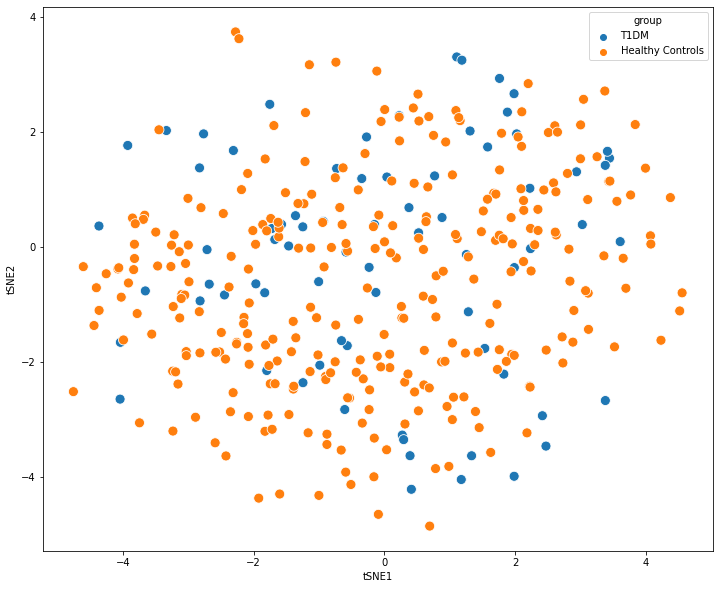

In [107]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib
tsne =TSNE(n_components=2, init='random', perplexity = 100, random_state=0)


X_tsne = tsne.fit_transform(X)

vis_x = X_tsne[:, 0]
vis_y = X_tsne[:, 1]

res['Y'] = y
res.head()
res['tSNE1'] = vis_x
res['tSNE2'] = vis_y

plt.figure(figsize=(12, 10))
sns.scatterplot(res['tSNE1'], res['tSNE2'], hue=res['group'], s=100)

In [112]:
from DataLoaders import DietLoggingLoader
dll = DietLoggingLoader.DietLoggingLoader()

dlld = dll.get_data(study_ids=[1])


log = dll.add_nutrients(dlld.df, nutrient_list=['energy_kcal',
 'carbohydrate_g',
 'protein_g',
 'totallipid_g',
 'totaldietaryfiber_g',
 'totalsaturatedfattyacids_g']).reset_index()

log = log.groupby('RegistrationCode')[['energy_kcal',
 'carbohydrate_g',
 'protein_g',
 'totallipid_g',]].sum()

log['carb_perc'] = log['carbohydrate_g']/log['energy_kcal']*400
log['proten_perc'] = log['protein_g']/log['energy_kcal']*400
log['totallipid_g'] = log['totallipid_g']/log['energy_kcal']*900

log[['carb_perc', 'proten_perc', 'totallipid_g']].describe()

,carb_perc,proten_perc,totallipid_g
count,1058.000000,1058.000000,1058.000000
mean,46.207253,15.345045,36.148968
std,7.494824,3.259541,6.551562
min,0.000000,6.365671,5.235707
25%,42.404655,13.175131,32.471992
50%,46.779919,14.968200,35.729119
75%,50.669825,17.077575,39.194298
max,86.659980,33.356976,81.000000


In [95]:
def bacteria_name(x):
    if x.split('|')[6].replace('s__', '')!='unknown':
        return x.split('|')[6].replace('s__', '')+'_'+ x.split('|')[9]
    elif x.split('|')[5].replace('g__', '')!='unknown':
        return x.split('|')[5].replace('g__', '')+' '+x.split('|')[9]
    elif x.split('|')[4].replace('f__', '')!='unknown':
        return x.split('|')[4].replace('f__', '')+' '+x.split('|')[9]
    else:
        return x.split('|')[9]
    
    
X = X.rename(columns = {col:bacteria_name(col).replace('unclassified', '') for col in X.columns})

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


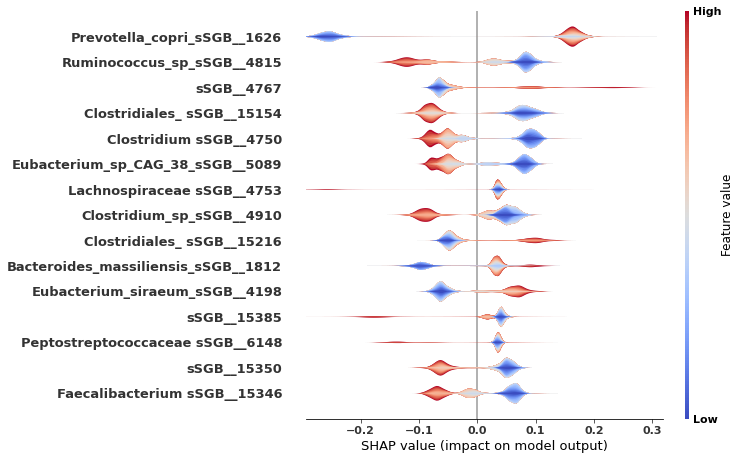

In [96]:
import shap
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 8]

fitted = classifier.fit(X, y)



shap_values = shap.TreeExplainer(fitted)

import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

shap_values = shap_values.shap_values(X)
fig = shap.summary_plot(shap_values, X, max_display=15, plot_type="layered_violin", color='coolwarm', show=False)


plt.savefig('/net/mraid08/export/genie/LabData/Data/StudySpecificData/T1D//microbiome//predictor_t1d_hc_shap.jpg', dpi=800,bbox_inches='tight')
#p

In [ ]:
set_both_all_known[[col for col in set_both_all_known if 'no_consensus' not in col]]

In [ ]:
set_grouped = pd.DataFrame()
set_both_all_known = set_both_all_known[[col for col in set_both_all_known if 'no_consensus' not in col]]
for col_new in set([c.split('SGB')[0] for c in set_both_all_known.columns]):
    if col_new!='group':
        set_grouped[col_new[:-2]] = set_both_all_known[[col for col in set_both_all_known.columns if col_new in col]].sum(axis=1)
set_grouped['group'] =    set_both_all_known['group']   
set_grouped.T.to_csv('/net/mraid08/export/genie/LabData/Data/StudySpecificData/T1D//microbiome//X1_y_1_T_abund_known_grouped.csv', sep='\t')
    

In [ ]:
y.name = 'is_t1d'
X.reset_index().join(y).T.to_csv('/net/mraid08/export/genie/LabData/Data/StudySpecificData/T1D//microbiome//X_y_1_T.csv', sep='\t')

In [ ]:
set1['is t1d'] = 1

set2['is t1d'] = 0

X = set1.append(set2).fillna(-4)
X = X[[col for col in X.columns if 'unknown' not in col]]
y = X.reset_index()['is t1d']

#y = y.

del X['is t1d']
y1  =y.apply(lambda x: 'T1D' if x==1 else 'HC')
X1 = X.reset_index()
del X1['SampleName']
y1.name = 'is_t1d'
X1.join(y1).T.to_csv('/net/mraid08/export/genie/LabData/Data/StudySpecificData/T1D//microbiome//X1_y_1_T_known.csv', sep='\t')

In [ ]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

#shap_values = shap_values.shap_values(X)
fig = shap.summary_plot(shap_values, X, max_display=15, plot_type="layered_violin", color='coolwarm', show=False)


plt.savefig('/net/mraid08/export/genie/LabData/Data/StudySpecificData/T1D//microbiome//predictor_t1d_hc_shap.jpg', dpi=800,bbox_inches='tight')
#plt.savefig('/net/mraid08/export/genie/LabData/Data/StudySpecificData/T1D//microbiome//predictor_t1d_hc_shap.jpg', dpi=800)

In [148]:
y

0      1
1      1
2      1
3      1
4      1
      ..
365    0
366    0
367    0
368    0
369    0
Name: is t1d, Length: 370, dtype: int64

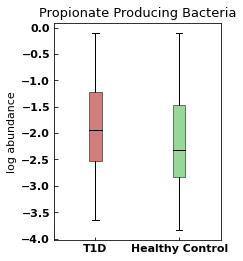

In [155]:
colors = [(0.7, 0.15, 0.15, 0.6), (0.5, 0.8, 0.5, 0.8)]


    
    
draw_plot(t1d_micr_features['accetate_producing'].apply(lambda x: np.log(x)).values, control_micr_features['accetate_producing'].apply(lambda x: np.log(x)).values, 'Propionate Producing Bacteria')

In [ ]:
colors = [(0.7, 0.15, 0.15, 0.6), (0.5, 0.8, 0.5, 0.8)]

def draw_plot(A, B, title=''):
    fig, ax = plt.subplots(figsize = [3, 4])
    bplot1 = ax.boxplot([A, B], vert=True,  patch_artist=True,  labels=['T1D', 'Healthy Control'], showfliers = False)  # will be used to label x-ticks
    for bplot in (bplot1,):
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_linewidth(0.5)
    for median in bplot['medians']:
        median.set(color='k', linewidth=1,)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(10)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(10)
    ax.set_title(title,  fontsize=12)
    ax.tick_params(direction='in')
    plt.show()
    
    
draw_plot(set1[faecalibacterium].sum(axis=1).values, set2[faecalibacterium].sum(axis=1).values, 'Faecalibacterium prausnitzii abundance')

In [ ]:
print(set1[faecalibacterium].sum(axis=1).mean())
print(set2[faecalibacterium].sum(axis=1).mean())


print(ttest_ind(set1[faecalibacterium].sum(axis=1), set2[faecalibacterium].sum(axis=1)))

print(do_mw(set1[faecalibacterium].sum(axis=1), set2[faecalibacterium].sum(axis=1)))

In [ ]:
all_mbl = GutMBLoader()
all_mb = all_mbl.get_data(df = 'segata_species', study_ids=[1000,6])
all_mb = all_mb.df
all_mb.head(3)
set1 = all_mb[all_mb.index.isin(t1d_adults['SampleName'].values)]

set2 = all_mb[all_mb.index.isin(control_d2_samples)]

print(ttest_ind(set1.fillna(0.0001).apply(lambda x: shannon_divercity(x), axis=1), set2.fillna(0.0001).apply(lambda x: shannon_divercity(x), axis=1)))
print(ttest_ind(set1.apply(lambda x: richness(x), axis=1), set2.apply(lambda x: richness(x), axis=1)))

In [ ]:
print(set1.fillna(0.0001).apply(lambda x: shannon_divercity(x), axis=1).mean(), set2.fillna(0.0001).apply(lambda x: shannon_divercity(x), axis=1).mean())
print(set1.apply(lambda x: richness(x), axis=1).mean(), set2.apply(lambda x: richness(x), axis=1).mean())

In [ ]:
all_mbl = GutMBLoader()
all_mb = all_mbl.get_data(df = 'segata_species', study_ids=[1000,6], take_log=True, min_col_present_frac=0.2)
all_mb = all_mb.df
all_mb.head(3)
set1 = all_mb[all_mb.index.isin(t1d_adults['SampleName'].values)]

set2 = all_mb[all_mb.index.isin(control_d2_samples)]


from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=105)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from scipy import interp
import numpy as np

set1['is t1d'] = 1

set2['is t1d'] = 0

X = set1.append(set2).fillna(-4)

y = pd.Series(np.random.randint(2, size=X.shape[0]))

#y = y.

del X['is t1d']

#class_weight = dict({0:1.9, 1:35})
#classifier = RandomForestClassifier()
classifier = GradientBoostingClassifier(n_estimators = 1000,learning_rate=.01,max_depth=4,max_features=1,min_samples_leaf=10)
#classifier = svm.SVC(kernel='linear', probability=True,
#                     random_state=random_state)
#
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
y_test_all = []
y_predict_all = []
y_pred = []
y_true = []
trhresh_all = []

i = 0
for i, (train, test) in enumerate(cv.split(X, y)):
    fitted = classifier.fit(X.iloc[train], y.iloc[train])
    probas_ = fitted.predict_proba(X.iloc[test])
   # y_pred += [fitted.predict(X.iloc[test])]
   # y_true +=[y.iloc[test]]
  #  y_predict_all+=[probas_[:, 1]]
  #  y_test_all+=[y.iloc[test]]
    fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
    trhresh_all+=[thresholds]
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3)
           #  label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Prediction of T1D from microbiome')
plt.legend(loc="lower right")
plt.show()

In [ ]:
ttest_ind(set1.fillna(0.0001).apply(lambda x: shannon_divercity(x), axis=1), set2.fillna(0.0001).apply(lambda x: shannon_divercity(x), axis=1))
ttest_ind(set1.apply(lambda x: richness(x), axis=1), set2.apply(lambda x: richness(x), axis=1))

In [ ]:

t1d_adults_numbers = pd.Series(list(t1d_adults.index))
t1d_adults_numbers.name='RegistrationCode'
t1d_adults.to_csv('/net/mraid08/export/genie/LabData/Data/StudySpecificData/T1D/t1d_adults.csv')

In [ ]:
pd.read_csv('/net/mraid08/export/genie/LabData/Data/StudySpecificData/T1D/t1d_adults.csv')

In [ ]:
list(control_d2_metadata['RegistrationCode'].values)

In [ ]:
list(control_meta.index)

In [ ]:
control_d2_metadata

#['StorageDT']

#.columns

In [ ]:
from DataLoaders.BodyMeasuresLoader import BodyMeasuresLoader

bml = BodyMeasuresLoader()

bmld = bml.get_data(study_ids=[6,1000])

bmld.df[bmld.df.index.get_level_values(0).isin(t1d_mbl.df_metadata['RegistrationCode'].values)]

In [ ]:
bmld.df.loc[control_d2_metadata['RegistrationCode'].values]['bmi'][bmld.df.loc[control_d2_metadata['RegistrationCode'].values]['bmi']<50].dropna().hist()

plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [5, 3]

bmld.df.loc[t1d_adults_numbers]['bmi'].dropna().hist()

plt.show()

In [ ]:
ttest_ind(bmld.df.loc[control_d2_metadata['RegistrationCode'].values]['bmi'].dropna(),bmld.df.loc[t2d_adults_numbers]['bmi'].dropna())

In [ ]:
from DataLoaders.GutMBLoader import GutMBLoader

mbl = GutMBLoader()

pnp3_mbl = mbl.get_data(df='segata_species', study_ids=17)

pnp3_mbl.df_metadata

In [ ]:
pnp3_mbl.df_metadata[pnp3_mbl.df_metadata['RegistrationCode'].isin(['117111', '724901', '297705', '258667', '279694', '979162', '57724', '922039', '381094',
'78283', '358113', '470856', '393528', '143892', '900460', '41275','745073', '328155', '132095'])].sort_values(['RegistrationCode', 'StorageDT'])

In [ ]:
['117111', '724901', '297705', '258667', '279694', '979162', '57724', '922039', '381094',
'78283', '358113', '470856', '393528', '143892', '900460', '41275','745073', '328155', '132095']


In [ ]:
from DataLoaders.SerumLoader import SerumLoader

In [ ]:
SerumLoader().get_data(study_ids=28).df_metadata

family

In [ ]:
all_mbl = GutMBLoader()
all_mb = all_mbl.get_data(df = 'segata_species', take_log=True, min_col_present_frac=0.2)

In [ ]:
family = pd.read_excel('/net/mraid08/export/genie/LabData/Data/StudySpecificData/T1D//family.xlsx')

In [ ]:
rel_pathways = pd.read_pickle('/net/mraid08/export/genie/LabData/Data/StudySpecificData/T1D/relative_pathways.df')
all_path =rel_pathways.notna().sum()
interesting_pathways = all_path[all_path>100].index
rel_pathways = interesting_pathways


In [ ]:
all_path =rel_pathways.notna().sum()
interesting_pathways = all_path[all_path>100].index

#.hist()